<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P5: Segmentez des clients d'un site e-commerce </span></font> </center>  

***

**Contexte**  
**Olist** est une entreprise brésilienne qui propose une solution de vente sue les marketplaces en ligne.
<img src="Olist.jpeg">
**Mission**   
Fournir à l'équipe marketing:  
* **une segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.  
* **une description actionable** de la segmentation et de sa logique sous-jacente pour une utilisation optimale.
* **une proposition de contrat de maintenance** basée sur une analyse de la stabilité des segments au cours du temps.

 <font size="4"> <span style="font-size: 1.5em" > **Partie 2: Modélisation** </span> </font> 

Ce notebook sera dédié à la segmentation des clients d'Olist.

## Importation des librairies Python pour DS

In [2]:
%load_ext pycodestyle_magic
%flake8_on 

In [142]:
# ------------------------------------------
# projet : données des clients Olist
# Auteur : Rim BAHROUN
# Date: Janvier 2023
# OpenClassrooms
# Notebook: 2/3
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import numpy as np
import pandas as pd
import csv
import missingno as msno  # missing data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pandas.plotting import parallel_coordinates
import plotly.express as px
from matplotlib.colors import ListedColormap
import squarify

from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from yellowbrick.cluster import KElbowVisualizer,\
                                SilhouetteVisualizer,\
                                InterclusterDistance

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

from itertools import product
import time

In [5]:
# pour afficher 165 colonnes ou lignes minimum
pd.set_option('display.max_column', 100)
pd.set_option('display.max_row', 100)

## Fonctions utilent

In [84]:
def pca_visualisation_2d(X_scaled_clustered, df_centers, nom_model, pca):
    '''
    X_scaled_clustered: dataframe avec les données + cluster + color
    df_centers: dataframe avec les coordonnées des centres des clusters
    nom_model: string exp '5-means, 7-features'
    '''
    # projeter X sur les composantes principales
    X_projected = pca.transform(X_scaled_clustered.iloc[:, :-2])
    X_center_projected = pca.transform(df_centers.iloc[:, :-2])

    f, axes = plt.subplots(1, 2, figsize=(16, 7))
    bd = 10

    axes[0].scatter(X_projected[:, 0],
                    X_projected[:, 1],
                    c=X_scaled_clustered['color'],
                    alpha=0.2)
    axes[0].scatter(X_center_projected[:, 0], 
                    X_center_projected[:, 1],
                    c=df_centers.index,
                    marker='o',
                    alpha=1)
    axes[0].scatter(X_center_projected[:, 0],
                    X_center_projected[:, 1],
                    c='black',  # c=df_centers.index,
                    marker='x',
                    alpha=0.5)

    axes[1].scatter(X_center_projected[:, 0],
                    X_center_projected[:, 1],
                    s=df_centers['cluster_size'],
                    c=df_centers.index,
                    marker='o',
                    alpha=0.4)
    axes[1].scatter(X_center_projected[:, 0],
                    X_center_projected[:, 1],
                    c=df_centers.index,
                    marker='x')

    for i in range(2):
        axes[i].set_title('Segmentation des clients: {}'.format(nom_model),
                          fontsize=16, fontweight="bold")
        axes[i].set_xlabel('PC1')
        axes[i].set_ylabel('PC2')
        axes[i].set_xbound(-bd, bd)
        axes[i].set_ybound(-bd, bd)

    plt.show()

In [72]:
def visualisation_centres_features(df_centers, nom_model):
    '''
    df_centers: dataframe avec les coordonnées des centres des clusters
    nom_model: string exp '5-means, 7-features'
    '''
    df = df_centers
    palette = list(df.index)

    f, axes = plt.subplots(1, 2, figsize=(18, 8))
    squarify.plot(sizes=df['cluster_size'],
                  label=df.index,
                  color=palette,
                  alpha=0.8,
                  ax=axes[0])
    axes[0].set_title("Segmentation:{}".format(nom_model),
                      fontsize=18, fontweight="bold")

    sns.lineplot(data=df.iloc[:, :-2].T,
                 palette=palette,
                 ax=axes[1])
    axes[1].set_title('Coordonnées des centres des clusters',
                      fontsize=18, fontweight="bold")
    plt.xticks(rotation=10)
    plt.show()
    
    # Polar figure
    df_ = df.iloc[:, :-2].T.reset_index().rename(columns={'index': 'variables'})
    dff = df_.melt(id_vars=['variables'], value_vars=df_.columns, ignore_index=False)

    fig = px.line_polar(dff,
                  r="value",
                  theta="variables",
                  color="color",
                  line_close=True,
                  color_discrete_sequence=palette) 
    fig.show()

In [245]:
def dbscan_function(eps, min_sample):
    '''
    Renvoie un DataFrame avec les variables suivantes:
    eps, min_sample, n_clusters, noise %, silhouette score,
    cluster_0 %, cluster_1 %, cluster_2 %, cluster_3 %, cluster_4 %
    '''
    df_result = pd.DataFrame({})
    df_result['eps'] = [eps]
    df_result['min_sample'] = min_sample

    # entrainement du DBSCAN
    # Create DBSCAN clustering model
    dbscan = DBSCAN(eps=eps, min_samples=min_sample)

    # Fit the data to the model
    dbscan.fit(X_scaled)

    # Determine which clusters each data point belongs to:
    clusters = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
    df_result['n_clusters'] = int(n_clusters_)
    n_noise_ = list(clusters).count(-1)
    df_result['noise %'] = round(100*n_noise_/len(clusters))

    # Silouhette score.
    sil_score = round(silhouette_score(X_scaled, clusters), 2)
    df_result['silhouette score'] = sil_score

    # Normalized size of clusters.
    clusters_noiseless = clusters[clusters >= 0]
    cluster_size_ = np.round(100*np.bincount(clusters_noiseless)/len(clusters))
    cluster_size_ = cluster_size_.astype(int)

    df_result['cluster_0 %'] = cluster_size_[0]
    df_result['cluster_1 %'] = (cluster_size_[1]
                                if len(cluster_size_) > 1 else 0)
    df_result['cluster_2 %'] = (cluster_size_[2]
                                if len(cluster_size_) > 2 else 0)
    df_result['cluster_3 %'] = (cluster_size_[3]
                                if len(cluster_size_) > 3 else 0)
    df_result['cluster_4 %'] = (cluster_size_[4]
                                if len(cluster_size_) > 4 else 0)

    return df_result

In [248]:
def dbscan_eps_min_visualisation(df_eps_min):
    '''
    Fonction de visualisation des performances de DBSCAN
    en fonction des paramètres eps et min_sample.
    '''
    f, axes = plt.subplots(3, 2, figsize=(16, 16))
    axes = axes.ravel()

    df_dic = {}
    col_list = df_eps_min.columns[2:-2]
    for col, i in zip(col_list, range(len(col_list))):
        df_dic[col] = pd.pivot_table(df_eps_min,
                                     values=col,
                                     index='min_sample',
                                     columns='eps')
        sns.heatmap(df_dic[col],
                    annot=True,
                    annot_kws={"size": 12},
                    cmap="YlGnBu",
                    cbar=False,
                    ax=axes[i])
        axes[i].set_title(col, fontsize=16, fontweight="bold")

    plt.show()

## Importation des données

In [6]:
# importation des données
olist_clients = pd.read_csv('olist_clients.csv')
olist_clients = olist_clients.set_index('customer_unique_id')

In [10]:
olist_clients.head(2)

localisation  frequency        date_commande  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2           SP          1  2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f           SP          1  2018-05-07 11:11:27   

                                  nbr_jour_livraison  recency  avis  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2                   6      161     5   
0000b849f77a49e4a4ce2b2a4ca5be3f                   3      164     4   

                                  nbr_versement_moyen  monetory  \
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2                    8    141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f                    1     27.19   

                                  payement_moyen  nbr_total_article  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2          141.90                  1   
0000b849f77a49e4a4ce2b2a4ca5be3f           27.19                  1   

                                  nbr_moyen_article  nbr_produit_different  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2                  1                      1   
0000b849f77a49e4a4ce2b2a4ca5be3f                  1                      1   

                                  nbr_moyen_produit_different  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2                            1   
0000b849f77a49e4a4ce2b2a4ca5be3f                            1   

                                        categorie_produit  
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2  Home_FurnitureAndGarden  
0000b849f77a49e4a4ce2b2a4ca5be3f          HealthAndBeauty

In [ ]:
olist_clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94983 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   localisation                 94983 non-null  object 
 1   frequency                    94983 non-null  int64  
 2   date_commande                94983 non-null  object 
 3   nbr_jour_livraison           94983 non-null  int64  
 4   recency                      94983 non-null  int64  
 5   avis                         94983 non-null  int64  
 6   nbr_versement_moyen          94983 non-null  int64  
 7   monetory                     94983 non-null  float64
 8   payement_moyen               94983 non-null  float64
 9   nbr_total_article            94983 non-null  int64  
 10  nbr_moyen_article            94983 non-null  int64  
 11  nbr_produit_different        94983 non-null  int64  
 12  nbr_moyen_produit_dif

In [ ]:
olist_clients.describe()

frequency  nbr_jour_livraison       recency          avis  \
count  94983.000000        94983.000000  94983.000000  94983.000000   
mean       1.033859           12.755261    288.334197      4.112231   
std        0.210811            9.751876    152.984601      1.311498   
min        1.000000            0.000000     45.000000      1.000000   
25%        1.000000            7.000000    164.000000      4.000000   
50%        1.000000           10.000000    269.000000      5.000000   
75%        1.000000           16.000000    397.000000      5.000000   
max       16.000000          210.000000    774.000000      5.000000   

       nbr_versement_moyen      monetory  payement_moyen  nbr_total_article  \
count         94983.000000  94983.000000    94983.000000       94983.000000   
mean              2.918554    165.696655      160.755547           1.180222   
std               2.693021    226.747246      219.903759           0.620593   
min               0.000000      9.590000        9.590000           1.000000   
25%               1.000000     63.100000       62.435000           1.000000   
50%               2.000000    107.900000      105.750000           1.000000   
75%               4.000000    182.945000      176.990000           1.000000   
max              24.000000  13664.080000    13664.080000          24.000000   

       nbr_moyen_article  nbr_produit_different  nbr_moyen_produit_different  
count       94983.000000           94983.000000                 94983.000000  
mean            1.140730               1.073382                     1.038049  
std             0.528323               0.328673                     0.223357  
min             1.000000               1.000000                     1.000000  
25%             1.000000               1.000000                     1.000000  
50%             1.000000               1.000000                     1.000000  
75%             1.000000               1.000000                     1.000000  
max            21.000000              16.000000                     8.000000

In [ ]:
olist_clients.describe(include='O')

localisation        date_commande        categorie_produit
count         94983                94983                    94983
unique           27                94727                       13
top              SP  2017-11-20 10:59:08  Home_FurnitureAndGarden
freq          39740                    3                    31174

# Modélisation sur tous les données

## Données RFM

In [ ]:
olist_clients_rfm = olist_clients.loc[:, ['recency', 'frequency', 'monetory']]
print('olist_clients_rfm: ', olist_clients_rfm.shape)
olist_clients_rfm.head()

olist_clients_rfm:  (94983, 3)


recency  frequency  monetory
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19
0000f46a3911fa3c0805444483337064      587          1     86.22
0000f6ccb0745a6a4b88665a16c9f078      371          1     43.62
0004aac84e0df4da2b147fca70cf8255      338          1    196.89

In [ ]:
olist_clients_rfm.describe()

recency     frequency      monetory
count  94983.000000  94983.000000  94983.000000
mean     288.334197      1.033859    165.696655
std      152.984601      0.210811    226.747246
min       45.000000      1.000000      9.590000
25%      164.000000      1.000000     63.100000
50%      269.000000      1.000000    107.900000
75%      397.000000      1.000000    182.945000
max      774.000000     16.000000  13664.080000

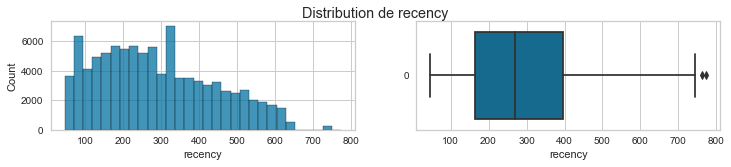

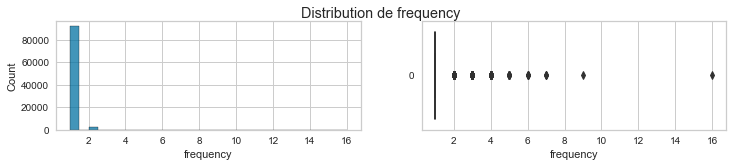

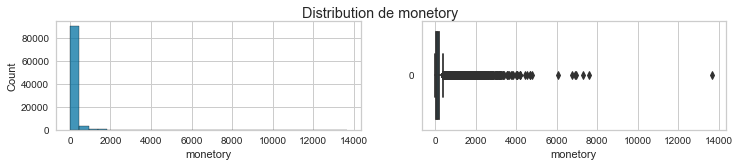

In [ ]:
for col in X.columns:
    f, axes = plt.subplots(1, 2, figsize=(12, 2))
    plt.suptitle("Distribution de {}".format(col))
    sns.histplot(data=X[col], bins=30, ax=axes[0])
    plt.suptitle("Distribution de {}".format(col))
    box_plot = sns.boxplot(data=X[col], ax=axes[1], orient="h")
    box_plot.set(xlabel=col)
    plt.show()

In [ ]:
X = olist_clients_rfm.copy()
X.head(2)

recency  frequency  monetory
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.83233781, -0.16061265, -0.10494849],
       [-0.81272789, -0.16061265, -0.61084484],
       [ 1.95227084, -0.16061265, -0.35050954],
       ...,
       [ 2.15490669, -0.16061265, -0.23478537],
       [-0.78004469, -0.16061265, -0.14115639],
       [ 1.60582892, -0.16061265, -0.41516337]])

### k-means clustering

**Nombre de clusters**

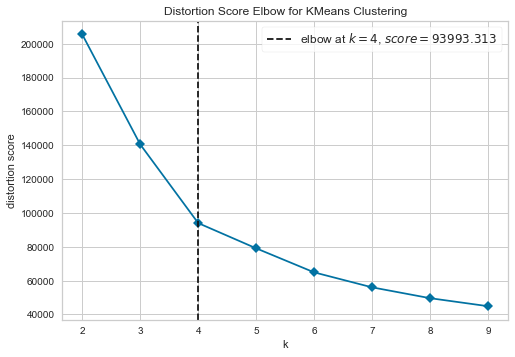

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

7:62: W291 trailing whitespace


In [ ]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans,
                              k=(2, 10),
                              timings=False)
# By default, the scoring parameter metric is set to distortion,
# which computes the sum of squared distances from each point
# to its assigned center.
visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.show()

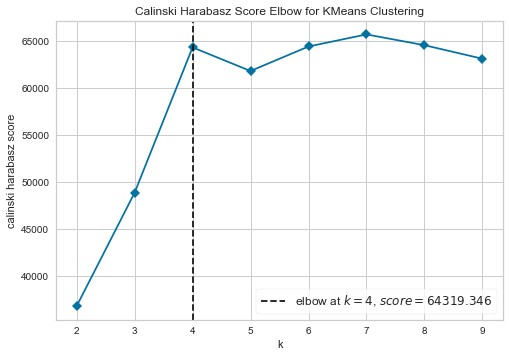

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [ ]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans,
                              k=(2, 10),
                              metric='calinski_harabasz',  # 'silhouette'
                              timings=False)
# calinski_harabasz score computes the ratio
# of dispersion between and within clusters.
# (v_interGroup/v_intraGroup)
visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.show()

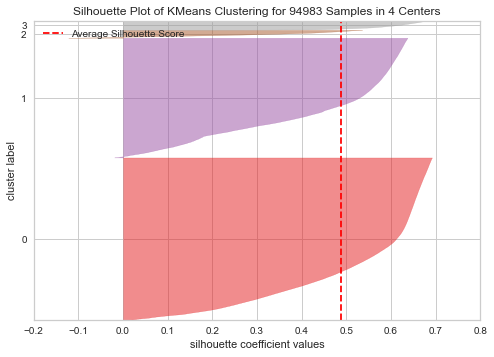

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94983 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(4)
visualizer_4means = SilhouetteVisualizer(model)

visualizer_4means.fit(X_scaled)    # Fit the data to the visualizer
visualizer_4means.poof()    # Draw/show/poof the data

Les clusters ne sont pas équilibrés. 

**4-means clustering**

In [ ]:
# entrainement du k-means avec la valeur 4
# Create a k-means clustering model
kmeans = KMeans(n_clusters=4)

# Fit the data to the model
kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to:
clusters = kmeans.predict(X_scaled)

In [ ]:
colors_map = {0: 'blue',  # bleu
              1: 'orange',  # orange
              2: 'green',  # vert
              3: 'red'}  # rouge
# Add cluster number and color to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters
X_scaled_clustered['color'] = X_scaled_clustered['cluster'].map(colors_map)
X_scaled_clustered.head()

recency  frequency  monetory  cluster  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2 -0.832338  -0.160613 -0.104948        0   
0000b849f77a49e4a4ce2b2a4ca5be3f -0.812728  -0.160613 -0.610845        0   
0000f46a3911fa3c0805444483337064  1.952271  -0.160613 -0.350510        2   
0000f6ccb0745a6a4b88665a16c9f078  0.540357  -0.160613 -0.538385        2   
0004aac84e0df4da2b147fca70cf8255  0.324647  -0.160613  0.137570        2   

                                  color  
customer_unique_id                       
0000366f3b9a7992bf8c76cfdf3221e2   blue  
0000b849f77a49e4a4ce2b2a4ca5be3f   blue  
0000f46a3911fa3c0805444483337064  green  
0000f6ccb0745a6a4b88665a16c9f078  green  
0004aac84e0df4da2b147fca70cf8255  green

In [ ]:
silhouette_score(X_scaled, clusters)

0.48822253313548825

In [ ]:
# fig = px.scatter_3d(X_scaled_clustered,
#                     x='recency',
#                     y='frequency',
#                     z='monetory',
#                     color='color')
# fig.show()

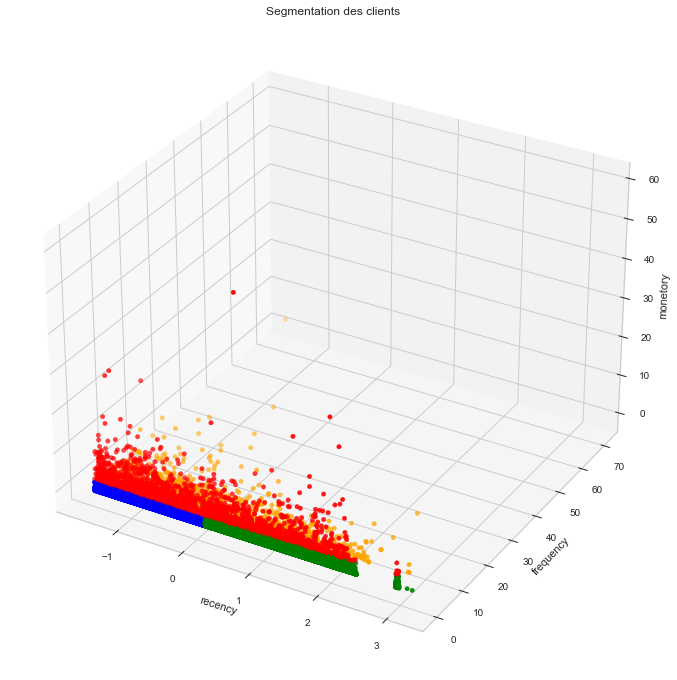

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
df = X_scaled_clustered.copy()

ax.scatter3D(df['recency'],
             df['frequency'],
             df['monetory'],
             c=df['color'])
ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetory')
ax.set_title('Segmentation des clients')
plt.show()

In [ ]:
# DataFrame des centres des clusters
color_list = ['blue', 'orange', 'green', 'red']

df_centers = pd.DataFrame(index=color_list, columns=X.columns)

df = X_scaled_clustered

for color in color_list:
    df_centers.loc[color, :] = df.loc[
        df['color'] == color, ['recency', 'frequency', 'monetory']].mean()
    count_color = df.loc[df['color'] == color, 'color'].shape[0]
    df_centers.loc[color, 'count'] = count_color

df_centers

recency frequency  monetory    count
blue   -0.718176 -0.160613 -0.137618  51592.0
orange -0.109619  5.125938  0.544233   2857.0
green   0.981475 -0.160613 -0.140968  38039.0
red     0.012424 -0.099773  4.371694   2495.0

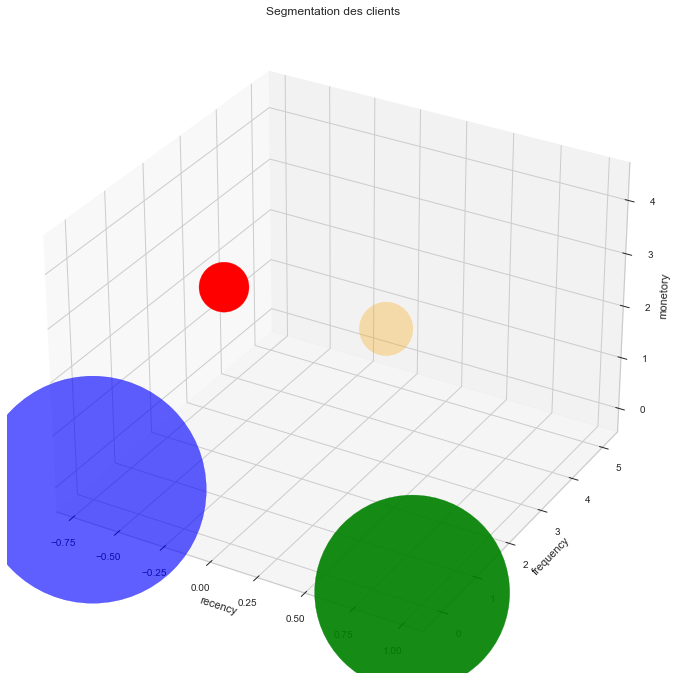

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

ax.scatter3D(df_centers['recency'],
             df_centers['frequency'],
             df_centers['monetory'],
             c=df_centers.index,
             s=df_centers['count'])

ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetory')
ax.set_title('Segmentation des clients')

plt.show()

In [ ]:
df_centers

recency frequency  monetory    count
blue   -0.718176 -0.160613 -0.137618  51592.0
orange -0.109619  5.125938  0.544233   2857.0
green   0.981475 -0.160613 -0.140968  38039.0
red     0.012424 -0.099773  4.371694   2495.0

In [ ]:
# coordonnées des centres des clusters avec les ordres de grandeur initials
centers_invers = scaler.inverse_transform(df_centers.iloc[:, :-1])\
                .round().astype(int)
# Convert to a data frame
df_centers_invers = pd.DataFrame(centers_invers,
                                 index=df_centers.index,
                                 columns=X.columns)
df_centers_invers['count'] = df_centers['count']

df_centers_invers

recency  frequency  monetory    count
blue        178          1       134  51592.0
orange      272          2       289   2857.0
green       438          1       134  38039.0
red         290          1      1157   2495.0

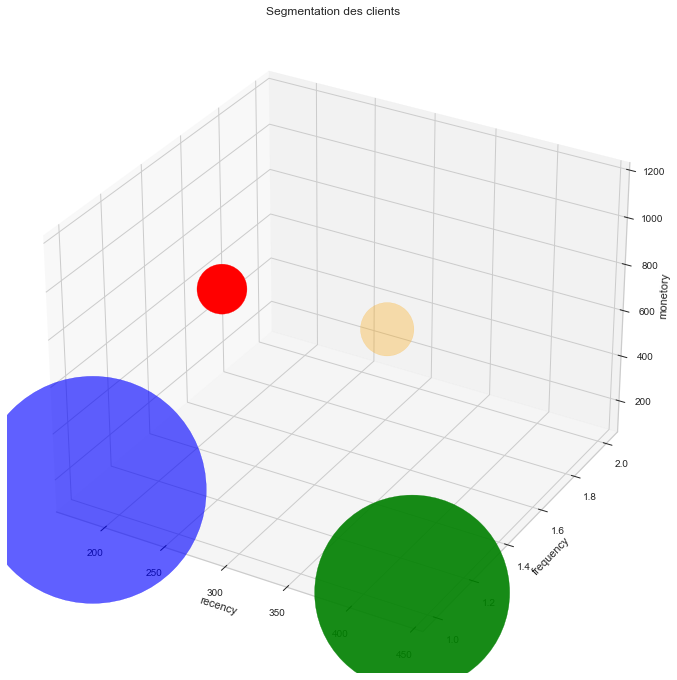

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

ax.scatter3D(df_centers_invers['recency'],
             df_centers_invers['frequency'],
             df_centers_invers['monetory'],
             c=df_centers_invers.index,
             s=df_centers_invers['count'])

ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetory')
ax.set_title('Segmentation des clients')

plt.show()

In [ ]:
df_centers_invers

recency  frequency  monetory    count
blue        178          1       134  51592.0
orange      272          2       289   2857.0
green       438          1       134  38039.0
red         290          1      1157   2495.0

In [ ]:
X_clustered = X.copy()
X_clustered['cluster'] = clusters
X_clustered['color'] = X_scaled_clustered['cluster'].map(colors_map)
X_clustered.head()

recency  frequency  monetory  cluster  color
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90        0   blue
0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19        0   blue
0000f46a3911fa3c0805444483337064      587          1     86.22        2  green
0000f6ccb0745a6a4b88665a16c9f078      371          1     43.62        2  green
0004aac84e0df4da2b147fca70cf8255      338          1    196.89        2  green

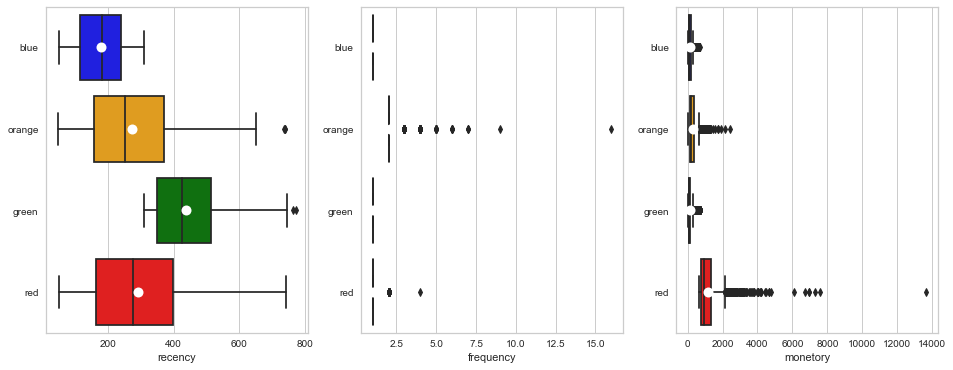

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(16, 6))
i = 0
for col in list(X_clustered.columns[:3]):
    box = sns.boxplot(x=col,
                      y="color",
                      orient='h',
                      order=['blue', 'orange', 'green', 'red'],
                      data=X_clustered,
                      showmeans=True,
                      meanprops={"marker": "o",
                                 "markerfacecolor": "white",
                                 "markeredgecolor": "black",
                                 "markersize": "10"},
                      palette=['blue', 'orange', 'green', 'red'],
                      ax=axes[i])
    box.set(ylabel='')
    i += 1

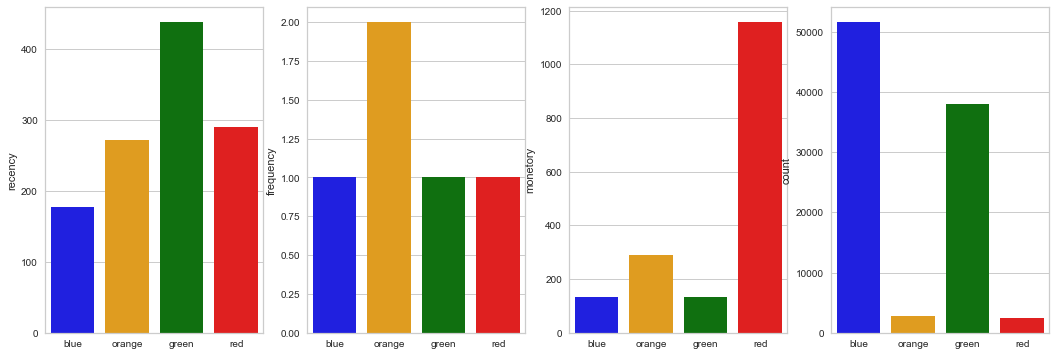

In [ ]:
# On trace la moyenne de chaque variable par cluster
df = df_centers_invers.copy()
f, axes = plt.subplots(1, 4, figsize=(18, 6))
i = 0
for col in list(df.columns):
    bar = sns.barplot(x=df.index,
                      y=df[col],
                      palette=['blue', 'orange', 'green', 'red'],
                      ax=axes[i])
    i += 1

plt.show()

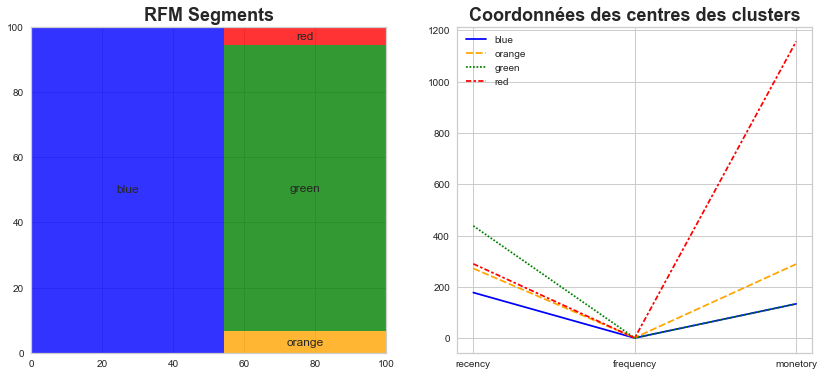

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(14, 6))
palette = ['blue', 'orange', 'green', 'red']
df = df_centers_invers

squarify.plot(sizes=df['count'],
              label=df.index,
              color=palette,
              alpha=0.8,
              ax=axes[0])
axes[0].set_title("RFM Segments", fontsize=18, fontweight="bold")


sns.lineplot(data=df.iloc[:, :-1].T,
             palette=palette,
             ax=axes[1])
axes[1].set_title('Coordonnées des centres des clusters',
                  fontsize=18, fontweight="bold")

plt.show()

In [ ]:
df_centers_invers

recency  frequency  monetory    count
blue        178          1       134  51592.0
orange      272          2       289   2857.0
green       438          1       134  38039.0
red         290          1      1157   2495.0

In [ ]:
# X_clustered.loc[:, 'frequency'].value_counts()

In [ ]:
# X_clustered.loc[X_clustered['color'] == 'orange', 'frequency'].value_counts()

In [ ]:
# X_clustered.loc[X_clustered['color'] == 'red', 'monetory'].describe()

### Analyse des résultats

Le modèle **k-means** entrainé avec 4 clusters donne:
* <font color='blue'> un **'blue'** correspondant à un nombre important de clients (soit 51K clients) qui ont acheté en moyenne 1 fois dans les derniers 6 mois et qui ont dépensé en moyenne 134 Réal brésilien (environ 25 euros). 
* <font color='green'> un **'green'** correspondant à un nombre important de clients (soit 38K clients) qui ont acheté en moyenne 1 fois dans la dernière année et qui ont dépensé en moyenne 134 Réal brésilien (environ 25 euros) comme le cluster 'blue'.   
* <font color='orange'> un **'orange'** **(Loyal)** correspondant à 2857 clients ayant acheté plus qu'une fois et ont dépensé en moyenne 289 Réal brésilien (environ 50 euros) soit le double des clients des cluster 'blue' et 'green'. Les achats des clients du cluster 'orange' remontent à plus de 6 mois en moyenne. C'est clients sont fidèles. 
* <font color='red'> un **'red'** **(Big spenders)** correspondant à 2495 clients ayant acheté en moyenne une seule fois dans cette année mais qui ont dépensé en moyenne beaucoup 1157 Réal brésilien (environ 200 euros).

**Les deux clusters 'blue' et 'green' se ressemblent beaucoup et ils comprennent à eu deux 89631 clients sur les 94983 (soit 94% des clients).** 
**La segmantation RFM n'est pas assez fine dans notre cas d'étude.  L'intégration d'autres variables sera ainsi nécessaires pour affiner le clustering.**

## Données avec variable catégorielle

### Prétraitement

In [ ]:
olist_clients.head(2)

localisation  frequency        date_commande  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2           SP          1  2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f           SP          1  2018-05-07 11:11:27   

                                  nbr_jour_livraison  recency  avis  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2                   6      161     5   
0000b849f77a49e4a4ce2b2a4ca5be3f                   3      164     4   

                                  nbr_versement_moyen  monetory  \
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2                    8    141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f                    1     27.19   

                                  payement_moyen  nbr_total_article  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2          141.90                  1   
0000b849f77a49e4a4ce2b2a4ca5be3f           27.19                  1   

                                  nbr_moyen_article  nbr_produit_different  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2                  1                      1   
0000b849f77a49e4a4ce2b2a4ca5be3f                  1                      1   

                                  nbr_moyen_produit_different  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2                            1   
0000b849f77a49e4a4ce2b2a4ca5be3f                            1   

                                        categorie_produit  
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2  Home_FurnitureAndGarden  
0000b849f77a49e4a4ce2b2a4ca5be3f          HealthAndBeauty

In [ ]:
olist_clients.describe()

frequency  nbr_jour_livraison       recency          avis  \
count  94983.000000        94983.000000  94983.000000  94983.000000   
mean       1.033859           12.755261    288.334197      4.112231   
std        0.210811            9.751876    152.984601      1.311498   
min        1.000000            0.000000     45.000000      1.000000   
25%        1.000000            7.000000    164.000000      4.000000   
50%        1.000000           10.000000    269.000000      5.000000   
75%        1.000000           16.000000    397.000000      5.000000   
max       16.000000          210.000000    774.000000      5.000000   

       nbr_versement_moyen      monetory  payement_moyen  nbr_total_article  \
count         94983.000000  94983.000000    94983.000000       94983.000000   
mean              2.918554    165.696655      160.755547           1.180222   
std               2.693021    226.747246      219.903759           0.620593   
min               0.000000      9.590000        9.590000           1.000000   
25%               1.000000     63.100000       62.435000           1.000000   
50%               2.000000    107.900000      105.750000           1.000000   
75%               4.000000    182.945000      176.990000           1.000000   
max              24.000000  13664.080000    13664.080000          24.000000   

       nbr_moyen_article  nbr_produit_different  nbr_moyen_produit_different  
count       94983.000000           94983.000000                 94983.000000  
mean            1.140730               1.073382                     1.038049  
std             0.528323               0.328673                     0.223357  
min             1.000000               1.000000                     1.000000  
25%             1.000000               1.000000                     1.000000  
50%             1.000000               1.000000                     1.000000  
75%             1.000000               1.000000                     1.000000  
max            21.000000              16.000000                     8.000000

In [ ]:
olist_clients.describe(include='O')

localisation        date_commande        categorie_produit
count         94983                94983                    94983
unique           27                94727                       13
top              SP  2017-11-20 10:59:08  Home_FurnitureAndGarden
freq          39740                    3                    31174

In [ ]:
olist_clients.columns

Index(['localisation', 'frequency', 'date_commande', 'nbr_jour_livraison',
       'recency', 'avis', 'nbr_versement_moyen', 'monetory', 'payement_moyen',
       'nbr_total_article', 'nbr_moyen_article', 'nbr_produit_different',
       'nbr_moyen_produit_different', 'categorie_produit'],
      dtype='object')

In [ ]:
# Selection des variables
data_columns = ['recency',
                'frequency',
                'monetory',
                'avis',
                'nbr_versement_moyen',
                'nbr_total_article',
                'categorie_produit']
data = olist_clients.loc[:, data_columns]

In [ ]:
data.head(2)

recency  frequency  monetory  avis  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90     5   
0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19     4   

                                  nbr_versement_moyen  nbr_total_article  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2                    8                  1   
0000b849f77a49e4a4ce2b2a4ca5be3f                    1                  1   

                                        categorie_produit  
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2  Home_FurnitureAndGarden  
0000b849f77a49e4a4ce2b2a4ca5be3f          HealthAndBeauty

In [ ]:
data.describe()

recency     frequency      monetory          avis  \
count  94983.000000  94983.000000  94983.000000  94983.000000   
mean     288.334197      1.033859    165.696655      4.112231   
std      152.984601      0.210811    226.747246      1.311498   
min       45.000000      1.000000      9.590000      1.000000   
25%      164.000000      1.000000     63.100000      4.000000   
50%      269.000000      1.000000    107.900000      5.000000   
75%      397.000000      1.000000    182.945000      5.000000   
max      774.000000     16.000000  13664.080000      5.000000   

       nbr_versement_moyen  nbr_total_article  
count         94983.000000       94983.000000  
mean              2.918554           1.180222  
std               2.693021           0.620593  
min               0.000000           1.000000  
25%               1.000000           1.000000  
50%               2.000000           1.000000  
75%               4.000000           1.000000  
max              24.000000          24.000000

In [ ]:
# scaling numerical features
data_scaled = data.select_dtypes(exclude='O')
numerical_columns = data_scaled.columns
scaler = StandardScaler()
data_scaled[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [ ]:
data_scaled.head(2)

recency  frequency  monetory      avis  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2 -0.832338  -0.160613 -0.104948  0.676916   
0000b849f77a49e4a4ce2b2a4ca5be3f -0.812728  -0.160613 -0.610845 -0.085575   

                                  nbr_versement_moyen  nbr_total_article  
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2             1.886904          -0.290404  
0000b849f77a49e4a4ce2b2a4ca5be3f            -0.712421          -0.290404

In [ ]:
# OneHotEncoding
categorical_columns = data.select_dtypes(include='O').columns

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(data[categorical_columns])

ohe_columns = [cat.removeprefix('categorie_produit_')
                for cat in list(ohe.get_feature_names_out())]

data_ohe = pd.DataFrame(index=data.index,
                        columns=ohe_columns,
                        data=ohe.fit_transform(data[categorical_columns]))

data_ohe.head(2)

AccessoriesAndDecor  Books  Electronics  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2                  0.0    0.0          0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                  0.0    0.0          0.0   

                                  Fashion  FoodAndDrink  HealthAndBeauty  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2      0.0           0.0              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0           0.0              1.0   

                                  Home_FurnitureAndGarden  Industry  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2                      1.0       0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      0.0       0.0   

                                  MarketPlace  MusicAndArts  Services  \
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2          0.0           0.0       0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f          0.0           0.0       0.0   

                                  ToysAndGames  unknown  
customer_unique_id                                       
0000366f3b9a7992bf8c76cfdf3221e2           0.0      0.0  
0000b849f77a49e4a4ce2b2a4ca5be3f           0.0      0.0

In [ ]:
data_scaled_ohe = pd.merge(data_scaled, data_ohe,
                           left_index=True, right_index=True)
data_scaled_ohe

recency  frequency  monetory      avis  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2 -0.832338  -0.160613 -0.104948  0.676916   
0000b849f77a49e4a4ce2b2a4ca5be3f -0.812728  -0.160613 -0.610845 -0.085575   
0000f46a3911fa3c0805444483337064  1.952271  -0.160613 -0.350510 -0.848066   
0000f6ccb0745a6a4b88665a16c9f078  0.540357  -0.160613 -0.538385 -0.085575   
0004aac84e0df4da2b147fca70cf8255  0.324647  -0.160613  0.137570  0.676916   
...                                    ...        ...       ...       ...   
fffcf5a5ff07b0908bd4e2dbc735a684  1.363973  -0.160613  8.387019  0.676916   
fffea47cd6d3cc0a88bd621562a9d061  0.154695  -0.160613 -0.357742 -0.085575   
ffff371b4d645b6ecea244b27531430a  2.154907  -0.160613 -0.234785  0.676916   
ffff5962728ec6157033ef9805bacc48 -0.780045  -0.160613 -0.141156  0.676916   
ffffd2657e2aad2907e67c3e9daecbeb  1.605829  -0.160613 -0.415163  0.676916   

                                  nbr_versement_moyen  nbr_total_article  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2             1.886904          -0.290404   
0000b849f77a49e4a4ce2b2a4ca5be3f            -0.712421          -0.290404   
0000f46a3911fa3c0805444483337064             1.886904          -0.290404   
0000f6ccb0745a6a4b88665a16c9f078             0.401576          -0.290404   
0004aac84e0df4da2b147fca70cf8255             1.144240          -0.290404   
...                                               ...                ...   
fffcf5a5ff07b0908bd4e2dbc735a684             2.629568           1.320966   
fffea47cd6d3cc0a88bd621562a9d061            -0.712421          -0.290404   
ffff371b4d645b6ecea244b27531430a            -0.712421          -0.290404   
ffff5962728ec6157033ef9805bacc48             0.772908          -0.290404   
ffffd2657e2aad2907e67c3e9daecbeb             0.401576          -0.290404   

                                  AccessoriesAndDecor  Books  Electronics  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2                  0.0    0.0          0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                  0.0    0.0          0.0   
0000f46a3911fa3c0805444483337064                  0.0    0.0          1.0   
0000f6ccb0745a6a4b88665a16c9f078                  0.0    0.0          1.0   
0004aac84e0df4da2b147fca70cf8255                  0.0    0.0          1.0   
...                                               ...    ...          ...   
fffcf5a5ff07b0908bd4e2dbc735a684                  0.0    0.0          0.0   
fffea47cd6d3cc0a88bd621562a9d061                  0.0    0.0          0.0   
ffff371b4d645b6ecea244b27531430a                  0.0    0.0          0.0   
ffff5962728ec6157033ef9805bacc48                  1.0    0.0          0.0   
ffffd2657e2aad2907e67c3e9daecbeb                  0.0    0.0          0.0   

                                  Fashion  FoodAndDrink  HealthAndBeauty  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2      0.0           0.0              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0           0.0              1.0   
0000f46a3911fa3c0805444483337064      0.0           0.0              0.0   
0000f6ccb0745a6a4b88665a16c9f078      0.0           0.0              0.0   
0004aac84e0df4da2b147fca70cf8255      0.0           0.0              0.0   
...                                   ...           ...              ...   
fffcf5a5ff07b0908bd4e2dbc735a684      0.0           0.0              1.0   
fffea47cd6d3cc0a88bd621562a9d061      1.0           0.0              0.0   
ffff371b4d645b6ecea244b27531430a      0.0           0.0              0.0   
ffff5962728ec6157033ef9805bacc48      0.0           0.0              0.0   
ffffd2657e2aad2907e67c3e9daecbeb      0.0           0.0              1.0   

                                  Home_FurnitureAndGa

### k-means clustering

**Nombre de cluster**

In [ ]:
X = data_scaled_ohe.copy()

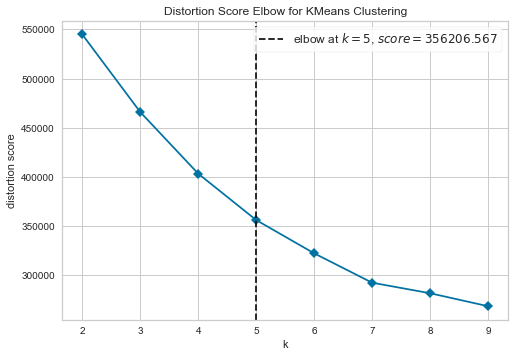

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans,
                              k=(2, 10),
                              timings=False)
# By default, the scoring parameter metric is set to distortion,
# which computes the sum of squared distances from each point
# to its assigned center.
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()

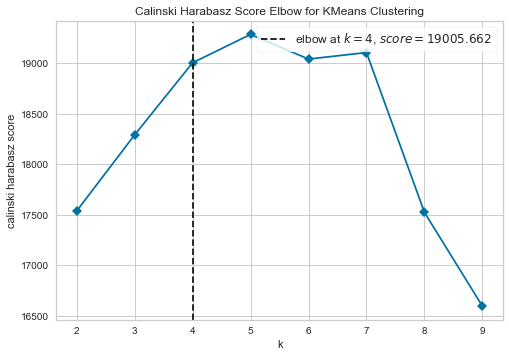

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [ ]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans,
                              k=(2, 10),
                              metric='calinski_harabasz',  # 'silhouette'
                              timings=False)
# calinski_harabasz score computes the ratio
# of dispersion between and within clusters.
# (v_interGroup/v_intraGroup)
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()

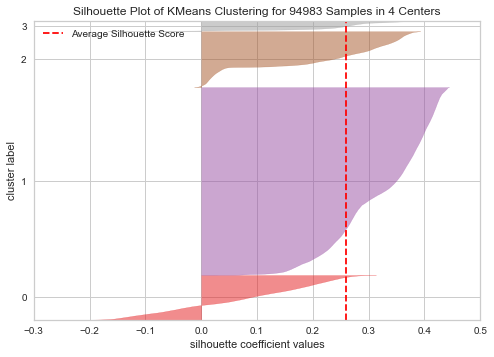

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94983 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(4)
visualizer_4means = SilhouetteVisualizer(model)

visualizer_4means.fit(X)    # Fit the data to the visualizer
visualizer_4means.poof()    # Draw/show/poof the data

In [ ]:
# entrainement du k-means avec la valeur 4
# Create a k-means clustering model
kmeans = KMeans(n_clusters=4)

# Fit the data to the model
kmeans.fit(X)

# Determine which clusters each data point belongs to:
clusters = kmeans.predict(X)

In [ ]:
colors_map = {0: 'blue',  # bleu
              1: 'orange',  # orange
              2: 'green',  # vert
              3: 'red'}  # rouge
# Add cluster number and color to the original data
X_scaled_clustered = X.copy()
X_scaled_clustered['cluster'] = clusters
X_scaled_clustered['color'] = X_scaled_clustered['cluster'].map(colors_map)
X_scaled_clustered.head()

recency  frequency  monetory      avis  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2 -0.832338  -0.160613 -0.104948  0.676916   
0000b849f77a49e4a4ce2b2a4ca5be3f -0.812728  -0.160613 -0.610845 -0.085575   
0000f46a3911fa3c0805444483337064  1.952271  -0.160613 -0.350510 -0.848066   
0000f6ccb0745a6a4b88665a16c9f078  0.540357  -0.160613 -0.538385 -0.085575   
0004aac84e0df4da2b147fca70cf8255  0.324647  -0.160613  0.137570  0.676916   

                                  nbr_versement_moyen  nbr_total_article  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2             1.886904          -0.290404   
0000b849f77a49e4a4ce2b2a4ca5be3f            -0.712421          -0.290404   
0000f46a3911fa3c0805444483337064             1.886904          -0.290404   
0000f6ccb0745a6a4b88665a16c9f078             0.401576          -0.290404   
0004aac84e0df4da2b147fca70cf8255             1.144240          -0.290404   

                                  AccessoriesAndDecor  Books  Electronics  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2                  0.0    0.0          0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                  0.0    0.0          0.0   
0000f46a3911fa3c0805444483337064                  0.0    0.0          1.0   
0000f6ccb0745a6a4b88665a16c9f078                  0.0    0.0          1.0   
0004aac84e0df4da2b147fca70cf8255                  0.0    0.0          1.0   

                                  Fashion  FoodAndDrink  HealthAndBeauty  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2      0.0           0.0              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0           0.0              1.0   
0000f46a3911fa3c0805444483337064      0.0           0.0              0.0   
0000f6ccb0745a6a4b88665a16c9f078      0.0           0.0              0.0   
0004aac84e0df4da2b147fca70cf8255      0.0           0.0              0.0   

                                  Home_FurnitureAndGarden  Industry  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2                      1.0       0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      0.0       0.0   
0000f46a3911fa3c0805444483337064                      0.0       0.0   
0000f6ccb0745a6a4b88665a16c9f078                      0.0       0.0   
0004aac84e0df4da2b147fca70cf8255                      0.0       0.0   

                                  MarketPlace  MusicAndArts  Services  \
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2          0.0           0.0       0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f          0.0           0.0       0.0   
0000f46a3911fa3c0805444483337064          0.0           0.0       0.0   
0000f6ccb0745a6a4b88665a16c9f078          0.0           0.0       0.0   
0004aac84e0df4da2b147fca70cf8255          0.0           0.0       0.0   

                                  ToysAndGames  unknown  cluster   color  
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2           0.0      0.0        1  orange  
0000b849f77a49e4a4ce2b2a4ca5be3f           0.0      0.0        0    blue  
0000f46a3911fa3c0805444483337064           0.0      0.0        1  orange  
0000f6ccb0745a6a4b88665a16c9f078           0.0      0.0        0    blue  
0004aac84e0df4da2b147fca70cf8255           0.0      0.0        1  orange

In [ ]:
X

recency  frequency  monetory      avis  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2 -0.832338  -0.160613 -0.104948  0.676916   
0000b849f77a49e4a4ce2b2a4ca5be3f -0.812728  -0.160613 -0.610845 -0.085575   
0000f46a3911fa3c0805444483337064  1.952271  -0.160613 -0.350510 -0.848066   
0000f6ccb0745a6a4b88665a16c9f078  0.540357  -0.160613 -0.538385 -0.085575   
0004aac84e0df4da2b147fca70cf8255  0.324647  -0.160613  0.137570  0.676916   
...                                    ...        ...       ...       ...   
fffcf5a5ff07b0908bd4e2dbc735a684  1.363973  -0.160613  8.387019  0.676916   
fffea47cd6d3cc0a88bd621562a9d061  0.154695  -0.160613 -0.357742 -0.085575   
ffff371b4d645b6ecea244b27531430a  2.154907  -0.160613 -0.234785  0.676916   
ffff5962728ec6157033ef9805bacc48 -0.780045  -0.160613 -0.141156  0.676916   
ffffd2657e2aad2907e67c3e9daecbeb  1.605829  -0.160613 -0.415163  0.676916   

                                  nbr_versement_moyen  nbr_total_article  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2             1.886904          -0.290404   
0000b849f77a49e4a4ce2b2a4ca5be3f            -0.712421          -0.290404   
0000f46a3911fa3c0805444483337064             1.886904          -0.290404   
0000f6ccb0745a6a4b88665a16c9f078             0.401576          -0.290404   
0004aac84e0df4da2b147fca70cf8255             1.144240          -0.290404   
...                                               ...                ...   
fffcf5a5ff07b0908bd4e2dbc735a684             2.629568           1.320966   
fffea47cd6d3cc0a88bd621562a9d061            -0.712421          -0.290404   
ffff371b4d645b6ecea244b27531430a            -0.712421          -0.290404   
ffff5962728ec6157033ef9805bacc48             0.772908          -0.290404   
ffffd2657e2aad2907e67c3e9daecbeb             0.401576          -0.290404   

                                  AccessoriesAndDecor  Books  Electronics  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2                  0.0    0.0          0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                  0.0    0.0          0.0   
0000f46a3911fa3c0805444483337064                  0.0    0.0          1.0   
0000f6ccb0745a6a4b88665a16c9f078                  0.0    0.0          1.0   
0004aac84e0df4da2b147fca70cf8255                  0.0    0.0          1.0   
...                                               ...    ...          ...   
fffcf5a5ff07b0908bd4e2dbc735a684                  0.0    0.0          0.0   
fffea47cd6d3cc0a88bd621562a9d061                  0.0    0.0          0.0   
ffff371b4d645b6ecea244b27531430a                  0.0    0.0          0.0   
ffff5962728ec6157033ef9805bacc48                  1.0    0.0          0.0   
ffffd2657e2aad2907e67c3e9daecbeb                  0.0    0.0          0.0   

                                  Fashion  FoodAndDrink  HealthAndBeauty  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2      0.0           0.0              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0           0.0              1.0   
0000f46a3911fa3c0805444483337064      0.0           0.0              0.0   
0000f6ccb0745a6a4b88665a16c9f078      0.0           0.0              0.0   
0004aac84e0df4da2b147fca70cf8255      0.0           0.0              0.0   
...                                   ...           ...              ...   
fffcf5a5ff07b0908bd4e2dbc735a684      0.0           0.0              1.0   
fffea47cd6d3cc0a88bd621562a9d061      1.0           0.0              0.0   
ffff371b4d645b6ecea244b27531430a      0.0           0.0              0.0   
ffff5962728ec6157033ef9805bacc48      0.0           0.0              0.0   
ffffd2657e2aad2907e67c3e9daecbeb      0.0           0.0              1.0   

                                  Home_FurnitureAndGa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



<AxesSubplot:title={'center':'Flattened Graph of 4 Clusters'}>

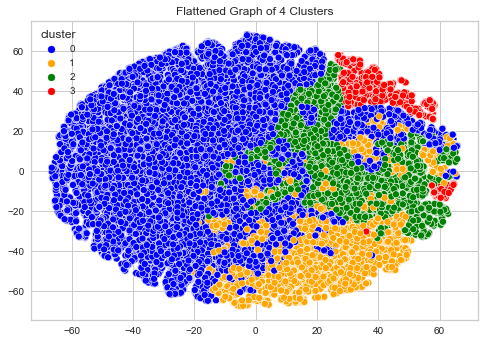

6:27: E231 missing whitespace after ','
7:27: E231 missing whitespace after ','


In [ ]:
tsne = TSNE(init='pca', perplexity=10)
X_tsne = tsne.fit_transform(X)

# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(4))
sns.scatterplot(x=X_tsne[:, 0],
                y=X_tsne[:, 1],
                hue=X_scaled_clustered.cluster,
                palette=palette)

In [ ]:
X

recency  frequency  monetory      avis  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2 -0.832338  -0.160613 -0.104948  0.676916   
0000b849f77a49e4a4ce2b2a4ca5be3f -0.812728  -0.160613 -0.610845 -0.085575   
0000f46a3911fa3c0805444483337064  1.952271  -0.160613 -0.350510 -0.848066   
0000f6ccb0745a6a4b88665a16c9f078  0.540357  -0.160613 -0.538385 -0.085575   
0004aac84e0df4da2b147fca70cf8255  0.324647  -0.160613  0.137570  0.676916   
...                                    ...        ...       ...       ...   
fffcf5a5ff07b0908bd4e2dbc735a684  1.363973  -0.160613  8.387019  0.676916   
fffea47cd6d3cc0a88bd621562a9d061  0.154695  -0.160613 -0.357742 -0.085575   
ffff371b4d645b6ecea244b27531430a  2.154907  -0.160613 -0.234785  0.676916   
ffff5962728ec6157033ef9805bacc48 -0.780045  -0.160613 -0.141156  0.676916   
ffffd2657e2aad2907e67c3e9daecbeb  1.605829  -0.160613 -0.415163  0.676916   

                                  nbr_versement_moyen  nbr_total_article  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2             1.886904          -0.290404   
0000b849f77a49e4a4ce2b2a4ca5be3f            -0.712421          -0.290404   
0000f46a3911fa3c0805444483337064             1.886904          -0.290404   
0000f6ccb0745a6a4b88665a16c9f078             0.401576          -0.290404   
0004aac84e0df4da2b147fca70cf8255             1.144240          -0.290404   
...                                               ...                ...   
fffcf5a5ff07b0908bd4e2dbc735a684             2.629568           1.320966   
fffea47cd6d3cc0a88bd621562a9d061            -0.712421          -0.290404   
ffff371b4d645b6ecea244b27531430a            -0.712421          -0.290404   
ffff5962728ec6157033ef9805bacc48             0.772908          -0.290404   
ffffd2657e2aad2907e67c3e9daecbeb             0.401576          -0.290404   

                                  AccessoriesAndDecor  Books  Electronics  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2                  0.0    0.0          0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                  0.0    0.0          0.0   
0000f46a3911fa3c0805444483337064                  0.0    0.0          1.0   
0000f6ccb0745a6a4b88665a16c9f078                  0.0    0.0          1.0   
0004aac84e0df4da2b147fca70cf8255                  0.0    0.0          1.0   
...                                               ...    ...          ...   
fffcf5a5ff07b0908bd4e2dbc735a684                  0.0    0.0          0.0   
fffea47cd6d3cc0a88bd621562a9d061                  0.0    0.0          0.0   
ffff371b4d645b6ecea244b27531430a                  0.0    0.0          0.0   
ffff5962728ec6157033ef9805bacc48                  1.0    0.0          0.0   
ffffd2657e2aad2907e67c3e9daecbeb                  0.0    0.0          0.0   

                                  Fashion  FoodAndDrink  HealthAndBeauty  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2      0.0           0.0              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0           0.0              1.0   
0000f46a3911fa3c0805444483337064      0.0           0.0              0.0   
0000f6ccb0745a6a4b88665a16c9f078      0.0           0.0              0.0   
0004aac84e0df4da2b147fca70cf8255      0.0           0.0              0.0   
...                                   ...           ...              ...   
fffcf5a5ff07b0908bd4e2dbc735a684      0.0           0.0              1.0   
fffea47cd6d3cc0a88bd621562a9d061      1.0           0.0              0.0   
ffff371b4d645b6ecea244b27531430a      0.0           0.0              0.0   
ffff5962728ec6157033ef9805bacc48      0.0           0.0              0.0   
ffffd2657e2aad2907e67c3e9daecbeb      0.0           0.0              1.0   

                                  Home_FurnitureAndGa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



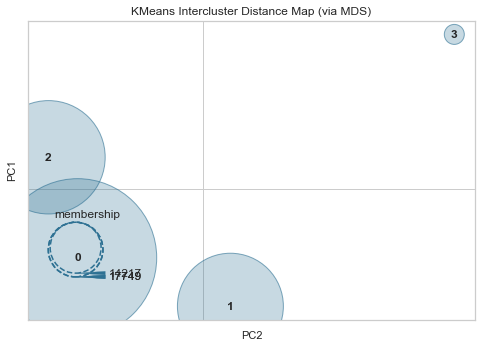

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [ ]:
# Instantiate the clustering model and visualizer
visualizer_interclusterdistance = InterclusterDistance(kmeans)

visualizer_interclusterdistance.fit(X)  # Fit the data to the visualizer
visualizer_interclusterdistance.show()  # Finalize and render the figure

In [ ]:
# DataFrame des centres des clusters
color_list = ['blue', 'orange', 'green', 'red']

df_centers = pd.DataFrame(index=color_list, columns=X.columns)

df = X_scaled_clustered

for color in color_list:
    df_centers.loc[color, :] = df.loc[df['color'] == color, :].mean()
    count_color = df.loc[df['color'] == color, 'color'].shape[0]
    df_centers.loc[color, 'count'] = count_color

df_centers

C:\Users\rimla\AppData\Local\Temp\ipykernel_32416\750250663.py:9: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\rimla\AppData\Local\Temp\ipykernel_32416\750250663.py:9: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



recency frequency  monetory      avis nbr_versement_moyen  \
blue   -0.031896 -0.160613 -0.222432   0.48039           -0.386366   
orange  0.135632 -0.160613  0.922204  0.137321            1.878076   
green   0.017576 -0.160613  -0.13501 -1.716065           -0.233469   
red     -0.10212  4.491864  0.784665 -0.058368            0.159796   

       nbr_total_article AccessoriesAndDecor     Books Electronics   Fashion  \
blue           -0.164004            0.141334  0.010513    0.182915  0.034768   
orange           0.01573             0.18288  0.004642    0.094886  0.030175   
green           0.003654            0.152065  0.005014    0.188067   0.03634   
red             2.899903            0.179323   0.00366    0.141507  0.028057   

       FoodAndDrink HealthAndBeauty Home_FurnitureAndGarden  Industry  \
blue       0.030717        0.206585                0.307811  0.004285   
orange     0.016811        0.187381                0.403601  0.005697   
green      0.023382        0.183447                0.330103  0.003324   
red        0.027447        0.200061                0.362611  0.003355   

       MarketPlace MusicAndArts  Services ToysAndGames   unknown    count  
blue      0.002812     0.009709   0.00149     0.052546  0.014513  59738.0  
orange    0.002603     0.014208  0.001055      0.04579  0.010269  14217.0  
green     0.002986     0.008733  0.001634     0.048115   0.01679  17749.0  
red       0.003355     0.005794   0.00183     0.032327  0.010674   3279.0

In [ ]:
# coordonnées des centres des clusters avec les ordres de grandeur initials
centers_invers = scaler.inverse_transform(
    df_centers.loc[:, numerical_columns]).round().astype(int)
# Convert to a data frame
df_centers_invers = pd.DataFrame(centers_invers,
                                 index=df_centers.index,
                                 columns=numerical_columns)
df_centers_invers[ohe_columns] = df_centers[ohe_columns]
df_centers_invers['count'] = df_centers['count']
df_centers_invers

recency  frequency  monetory  avis  nbr_versement_moyen  \
blue        283          1       115     5                    2   
orange      309          1       375     4                    8   
green       291          1       135     2                    2   
red         273          2       344     4                    3   

        nbr_total_article AccessoriesAndDecor     Books Electronics   Fashion  \
blue                    1            0.141334  0.010513    0.182915  0.034768   
orange                  1             0.18288  0.004642    0.094886  0.030175   
green                   1            0.152065  0.005014    0.188067   0.03634   
red                     3            0.179323   0.00366    0.141507  0.028057   

       FoodAndDrink HealthAndBeauty Home_FurnitureAndGarden  Industry  \
blue       0.030717        0.206585                0.307811  0.004285   
orange     0.016811        0.187381                0.403601  0.005697   
green      0.023382        0.183447                0.330103  0.003324   
red        0.027447        0.200061                0.362611  0.003355   

       MarketPlace MusicAndArts  Services ToysAndGames   unknown    count  
blue      0.002812     0.009709   0.00149     0.052546  0.014513  59738.0  
orange    0.002603     0.014208  0.001055      0.04579  0.010269  14217.0  
green     0.002986     0.008733  0.001634     0.048115   0.01679  17749.0  
red       0.003355     0.005794   0.00183     0.032327  0.010674   3279.0

In [ ]:
df_centers_invers.shape

(4, 20)

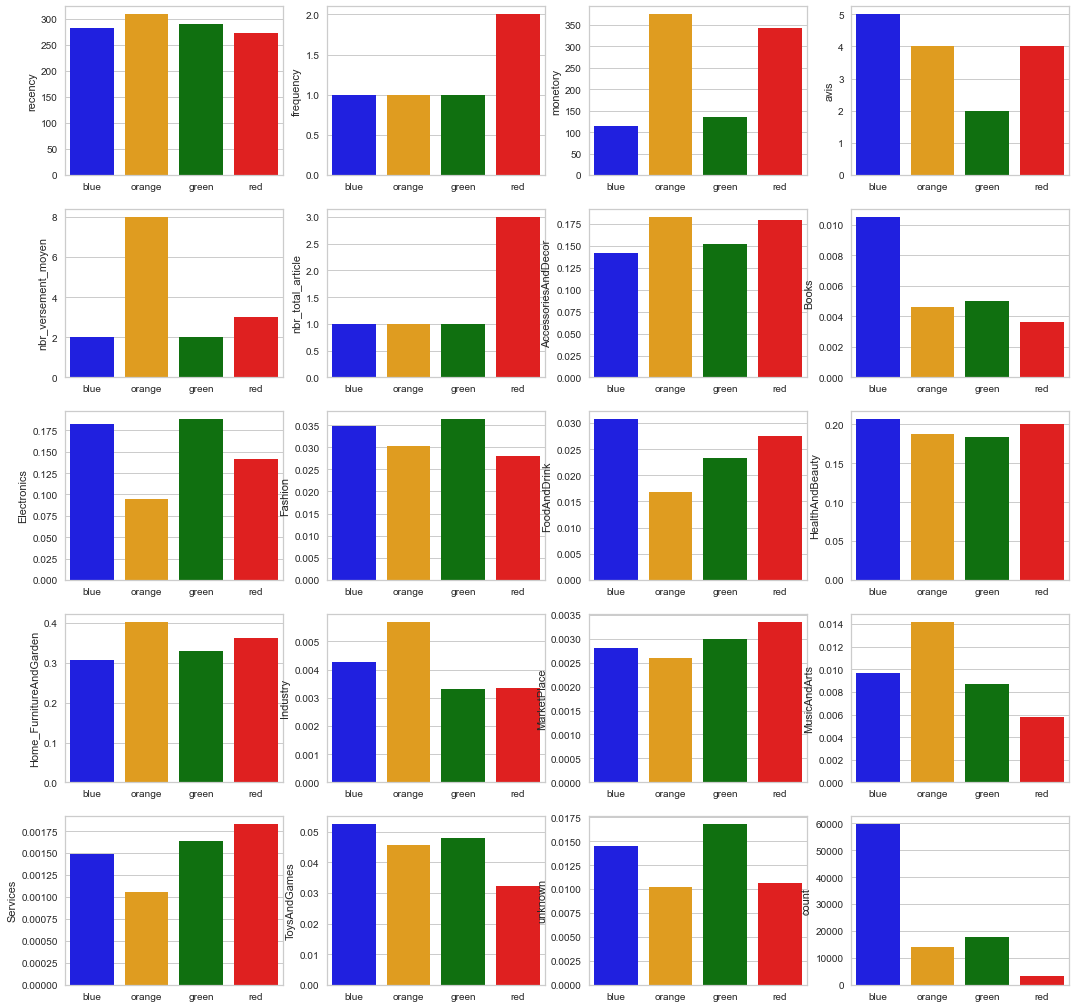

In [ ]:
# On trace la moyenne de chaque variable par cluster
df = df_centers_invers.copy()
f, axes = plt.subplots(5, 4, figsize=(18, 18))
k = 0
for i in range(5):
    for j in range(4):
        bar = sns.barplot(x=df.index,
                          y=df.iloc[:, k],
                          palette=['blue', 'orange', 'green', 'red'],
                          ax=axes[i, j])
        k += 1

plt.show()

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.24099792 0.1740139 ]
0.41501182420205474


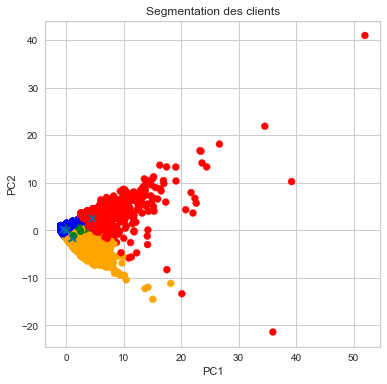

In [ ]:
# projeter X sur les composantes principales
X_projected = pca.transform(X)
x_center_projected = pca.transform(df_centers.iloc[:, :-1])
# afficher chaque observation
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
df = X_scaled_clustered.copy()

ax.scatter(X_projected[:, 0],
           X_projected[:, 1],
           c=X_scaled_clustered['color'])

ax.scatter(x_center_projected[:, 0],
           x_center_projected[:, 1],
           marker='x')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Segmentation des clients')
plt.show()

## Données sans variable catégorielle

### Prétraitement 

In [ ]:
olist_clients.columns

Index(['localisation', 'frequency', 'date_commande', 'nbr_jour_livraison',
       'recency', 'avis', 'nbr_versement_moyen', 'monetory', 'payement_moyen',
       'nbr_total_article', 'nbr_moyen_article', 'nbr_produit_different',
       'nbr_moyen_produit_different', 'categorie_produit'],
      dtype='object')

In [199]:
# Selection des variables
data_columns = ['recency',
                'frequency',
                'monetory',
                'avis',
                'nbr_jour_livraison',
                'nbr_versement_moyen',
                'nbr_total_article']
data = olist_clients.loc[:, data_columns]

In [ ]:
data.describe()

recency     frequency      monetory          avis  \
count  94983.000000  94983.000000  94983.000000  94983.000000   
mean     288.334197      1.033859    165.696655      4.112231   
std      152.984601      0.210811    226.747246      1.311498   
min       45.000000      1.000000      9.590000      1.000000   
25%      164.000000      1.000000     63.100000      4.000000   
50%      269.000000      1.000000    107.900000      5.000000   
75%      397.000000      1.000000    182.945000      5.000000   
max      774.000000     16.000000  13664.080000      5.000000   

       nbr_jour_livraison  nbr_versement_moyen  nbr_total_article  
count        94983.000000         94983.000000       94983.000000  
mean            12.755261             2.918554           1.180222  
std              9.751876             2.693021           0.620593  
min              0.000000             0.000000           1.000000  
25%              7.000000             1.000000           1.000000  
50%             10.000000             2.000000           1.000000  
75%             16.000000             4.000000           1.000000  
max            210.000000            24.000000          24.000000

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94983 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   recency              94983 non-null  int64  
 1   frequency            94983 non-null  int64  
 2   monetory             94983 non-null  float64
 3   avis                 94983 non-null  int64  
 4   nbr_jour_livraison   94983 non-null  int64  
 5   nbr_versement_moyen  94983 non-null  int64  
 6   nbr_total_article    94983 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 5.8+ MB


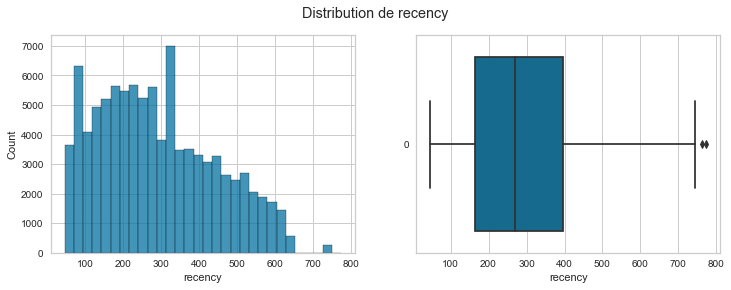

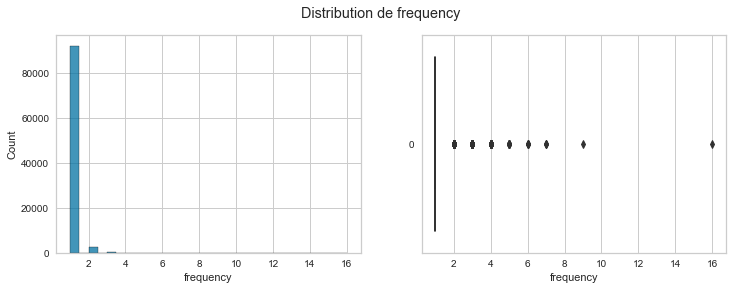

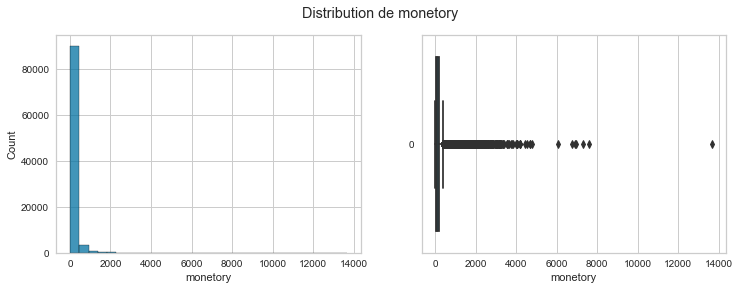

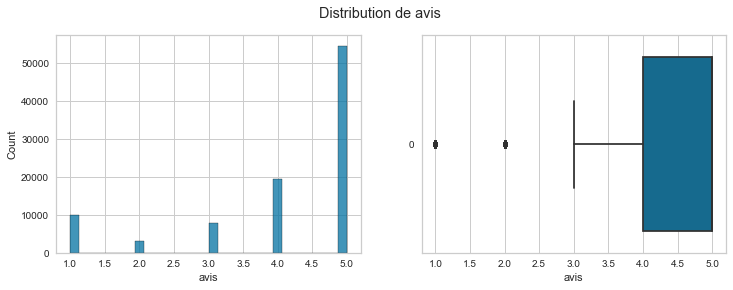

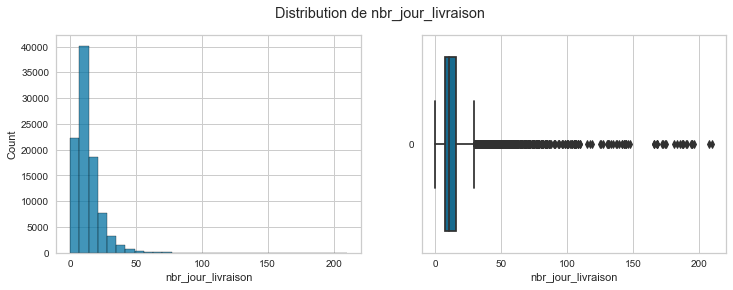

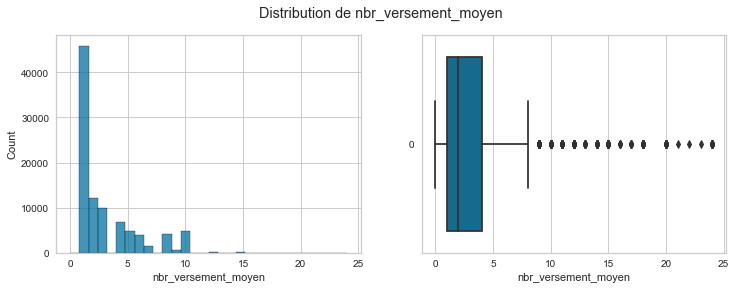

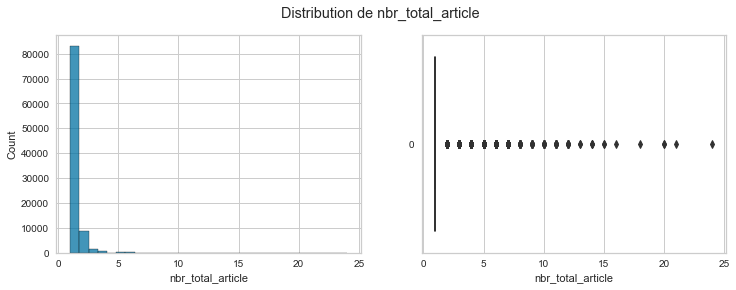

In [ ]:
num_columns = list(data.columns)
for col in num_columns:
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle("Distribution de {}".format(col))
    sns.histplot(data=olist_clients[col], bins=30, ax=axes[0])
    plt.suptitle("Distribution de {}".format(col))
    box_plot = sns.boxplot(data=olist_clients[col], ax=axes[1], orient="h")
    box_plot.set(xlabel=col)
    plt.show()

[Text(0.5, 0, 'monetory')]

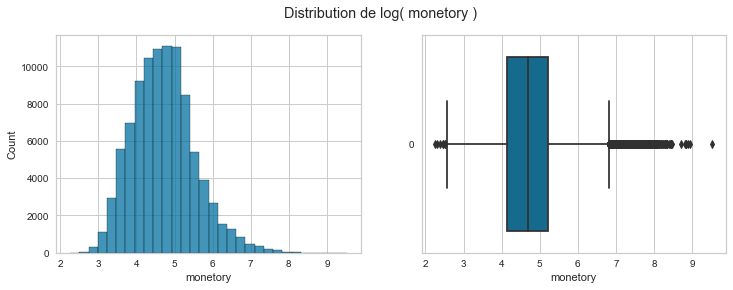

In [200]:
col = 'monetory'
f, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("Distribution de log( {} )".format(col))
sns.histplot(data=np.log(olist_clients[col]), bins=30, ax=axes[0])
plt.suptitle("Distribution de log( {} )".format(col))
box_plot = sns.boxplot(data=np.log(olist_clients[col]), ax=axes[1], orient="h")
box_plot.set(xlabel=col)

In [175]:
# data['monetory'] = np.log(data['monetory'])

In [201]:
# scaling numerical features
scaler = StandardScaler()
data_scaled_ = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data=data_scaled_,
                           index=data.index,
                           columns=data.columns)

In [177]:
data_scaled.describe()

recency     frequency      monetory          avis  \
count  9.498300e+04  9.498300e+04  9.498300e+04  9.498300e+04   
mean  -1.043446e-16 -1.029848e-15 -3.966485e-16 -6.783017e-16   
std    1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   
min   -1.590588e+00 -1.606126e-01 -3.007837e+00 -2.373047e+00   
25%   -8.127279e-01 -1.606126e-01 -7.030654e-01 -8.557481e-02   
50%   -1.263807e-01 -1.606126e-01 -4.676310e-02  6.769160e-01   
75%    7.103092e-01 -1.606126e-01  5.991366e-01  6.769160e-01   
max    3.174623e+00  7.099364e+01  5.875817e+00  6.769160e-01   

       nbr_jour_livraison  nbr_versement_moyen  nbr_total_article  
count        9.498300e+04         9.498300e+04       9.498300e+04  
mean        -4.700088e-16         6.500759e-17       7.781730e-16  
std          1.000005e+00         1.000005e+00       1.000005e+00  
min         -1.307987e+00        -1.083753e+00      -2.904039e-01  
25%         -5.901728e-01        -7.124207e-01      -2.904039e-01  
50%         -2.825381e-01        -3.410886e-01      -2.904039e-01  
75%          3.327314e-01         4.015757e-01      -2.904039e-01  
max          2.022644e+01         7.828218e+00       3.677111e+01

### 5-means clustering

In [342]:
X_scaled = data_scaled.copy()
X_scaled.shape

(94983, 7)

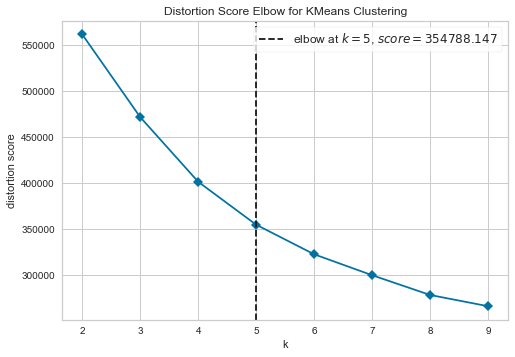

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [179]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans,
                              k=(2, 10),
                              timings=False)
# By default, the scoring parameter metric is set to distortion,
# which computes the sum of squared distances from each point
# to its assigned center.
visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.show()

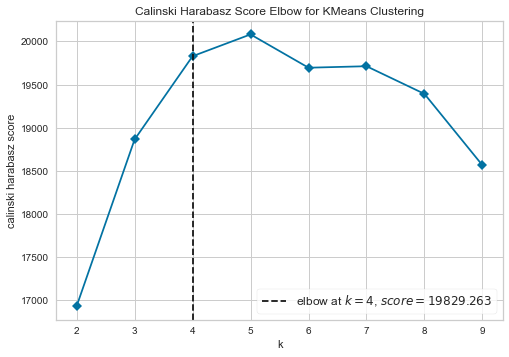

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [ ]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans,
                              k=(2, 10),
                              metric='calinski_harabasz',  # 'silhouette'
                              timings=False)
# calinski_harabasz score computes the ratio
# of dispersion between and within clusters.
# (v_interGroup/v_intraGroup)
visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.show()

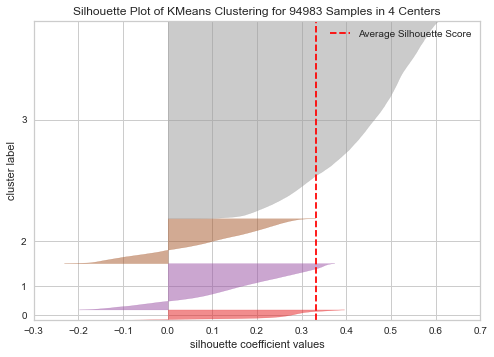

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94983 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(4)
visualizer_4means = SilhouetteVisualizer(model)

visualizer_4means.fit(X_scaled)    # Fit the data to the visualizer
visualizer_4means.poof()    # Draw/show/poof the data

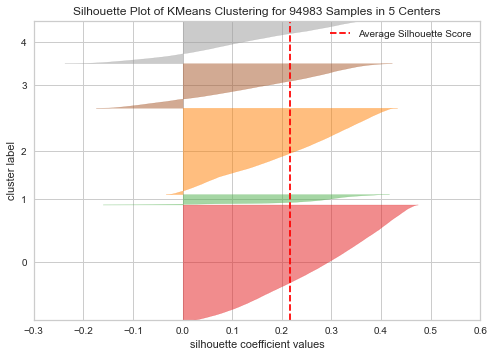

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94983 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [180]:
# Instantiate the clustering model and visualizer
model = KMeans(5, random_state=0)
visualizer_4means = SilhouetteVisualizer(model)

visualizer_4means.fit(X_scaled)    # Fit the data to the visualizer
visualizer_4means.poof()    # Draw/show/poof the data

In [343]:
# entrainement du k-means avec la valeur 5
# Create a k-means clustering model
kmeans = KMeans(n_clusters=5)

# Fit the data to the model
kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to:
clusters = kmeans.predict(X_scaled)

In [ ]:
silhouette_score(X_scaled, clusters)

In [ ]:
colors_map = {0: 'blue',  # bleu
              1: 'orange',  # orange
              2: 'green',  # vert
              3: 'red',  # rouge
              4: 'magenta'}  # jaune
# Add cluster number and color to the original data scaled
X_scaled_clustered = X_scaled.copy()
X_scaled_clustered['cluster'] = clusters
X_scaled_clustered['color'] = X_scaled_clustered['cluster'].map(colors_map)
X_scaled_clustered.head()

# Add cluster number and color to the original data not scaled
X_clustered = data.copy()
X_clustered['cluster'] = clusters
X_clustered['color'] = X_clustered['cluster'].map(colors_map)
X_clustered.head()

recency  frequency  monetory  avis  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90     5   
0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19     4   
0000f46a3911fa3c0805444483337064      587          1     86.22     3   
0000f6ccb0745a6a4b88665a16c9f078      371          1     43.62     4   
0004aac84e0df4da2b147fca70cf8255      338          1    196.89     5   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2                   6                    8   
0000b849f77a49e4a4ce2b2a4ca5be3f                   3                    1   
0000f46a3911fa3c0805444483337064                  26                    8   
0000f6ccb0745a6a4b88665a16c9f078                  20                    4   
0004aac84e0df4da2b147fca70cf8255                  13                    6   

                                  nbr_total_article  cluster   color  
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2                  1        4  yellow  
0000b849f77a49e4a4ce2b2a4ca5be3f                  1        2   green  
0000f46a3911fa3c0805444483337064                  1        4  yellow  
0000f6ccb0745a6a4b88665a16c9f078                  1        0    blue  
0004aac84e0df4da2b147fca70cf8255                  1        4  yellow

In [ ]:
tsne = TSNE(init='pca', perplexity=10)
X_tsne = tsne.fit_transform(X_scaled)

<AxesSubplot:title={'center':'Flattened Graph of 5 Clusters'}>

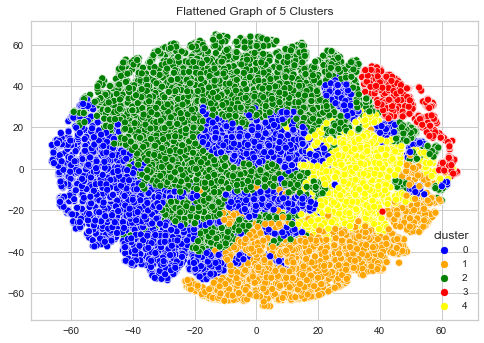

In [ ]:
palette = ['blue', 'orange', 'green', 'red', 'magenta']
# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(5))
sns.scatterplot(x=X_tsne[:, 0],
                y=X_tsne[:, 1],
                hue=X_scaled_clustered.cluster,
                palette=palette)

In [ ]:
df = X_scaled_clustered.copy()
df_centers = df.groupby('color').agg('mean')
df_centers['cluster_size'] = df.groupby('color').cluster.agg('count')
df_centers

recency  frequency  monetory      avis  nbr_jour_livraison  \
color                                                                 
blue    1.002650  -0.160613 -0.215757  0.357589           -0.117369   
green  -0.758430  -0.160613 -0.216523  0.389157           -0.306578   
orange  0.001886  -0.160613 -0.065189 -1.946458            1.122676   
red    -0.106819   4.511792  0.766727 -0.056140           -0.030009   
yellow  0.051366  -0.160214  1.066117  0.150599           -0.020287   

        nbr_versement_moyen  nbr_total_article  cluster  cluster_size  
color                                                                  
blue              -0.303141          -0.154891      0.0         28348  
green             -0.373762          -0.160922      2.0         37857  
orange            -0.114206           0.038764      1.0         13604  
red                0.155159           2.888893      3.0          3264  
yellow             1.997493           0.044182      4.0         11910

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.23638784 0.19652705]
0.4329148946043458


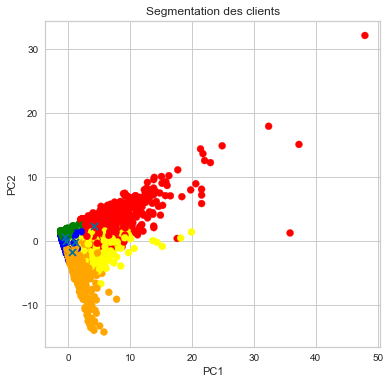

In [ ]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)
x_center_projected = pca.transform(df_centers.iloc[:, :-2])
# afficher chaque observation
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
df = X_scaled_clustered.copy()

ax.scatter(X_projected[:, 0],
           X_projected[:, 1],
           c=X_scaled_clustered['color'])

ax.scatter(x_center_projected[:, 0],
           x_center_projected[:, 1],
           marker='x')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Segmentation des clients')
plt.show()

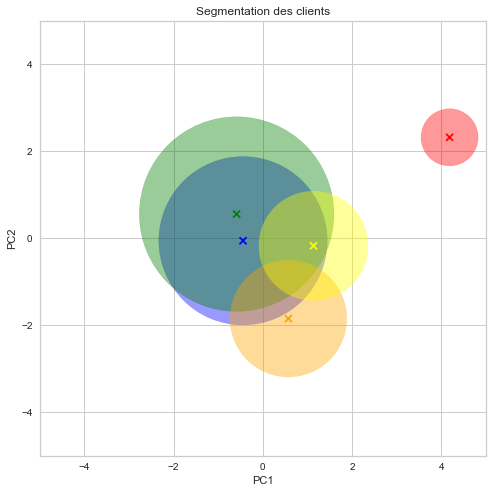

In [ ]:
# projeter X sur les composantes principales
x_center_projected = pca.transform(df_centers.iloc[:, :-2])
# afficher chaque observation
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
df = X_scaled_clustered.copy()

ax.scatter(x_center_projected[:, 0],
           x_center_projected[:, 1],
           s=df_centers['cluster_size'],
           c=df_centers.index,
           marker='o',
           alpha=0.4)
ax.scatter(x_center_projected[:, 0],
           x_center_projected[:, 1],
           c=df_centers.index,
           marker='x')


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Segmentation des clients')
ax.set_xbound(-5, 5)
ax.set_ybound(-5, 5)
plt.show()

In [ ]:
df = X_clustered.copy()
df_centers_invers = df.groupby('color').agg(lambda x: round(x.mean()))
df_centers_invers['cluster_size'] = df.groupby('color').cluster.agg('count')
df_centers_invers

recency  frequency  monetory  avis  nbr_jour_livraison  \
color                                                            
blue        442          1       117     5                  12   
green       172          1       117     5                  10   
orange      289          1       151     2                  24   
red         272          2       340     4                  12   
yellow      296          1       407     4                  13   

        nbr_versement_moyen  nbr_total_article  cluster  cluster_size  
color                                                                  
blue                      2                  1        0         28348  
green                     2                  1        2         37857  
orange                    3                  1        1         13604  
red                       3                  3        3          3264  
yellow                    8                  1        4         11910

In [ ]:
# f, axes = plt.subplots(1, 2, figsize=(18, 8))
# palette = ['blue', 'orange', 'green', 'red', 'yellow']
# df = df_centers_invers

# squarify.plot(sizes=df['cluster_size'],
#               label=df.index,
#               color=palette,
#               alpha=0.8,
#               ax=axes[0])
# axes[0].set_title("Segmentation: 5-means, 7-features",
#                   fontsize=18, fontweight="bold")


# sns.lineplot(data=df.iloc[:, :-2].T,
#              palette=palette,
#              ax=axes[1])
# axes[1].set_title('Coordonnées des centres des clusters',
#                   fontsize=18, fontweight="bold")
# plt.xticks(rotation=10)

# plt.show()

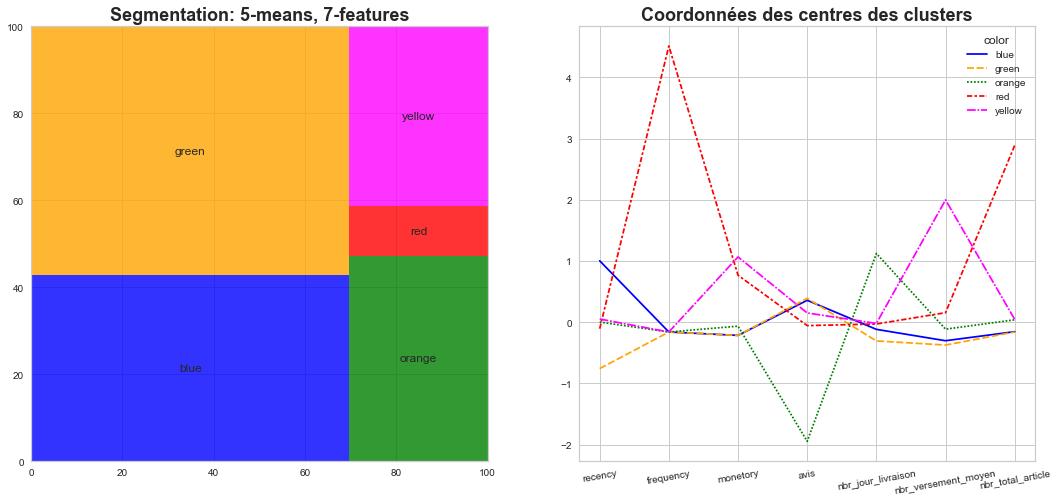

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(18, 8))
palette = ['blue', 'orange', 'green', 'red', 'magenta']
df = df_centers

squarify.plot(sizes=df['cluster_size'],
              label=df.index,
              color=palette,
              alpha=0.8,
              ax=axes[0])
axes[0].set_title("Segmentation: 5-means, 7-features",
                  fontsize=18, fontweight="bold")


sns.lineplot(data=df.iloc[:, :-2].T,
             palette=palette,
             ax=axes[1])
axes[1].set_title('Coordonnées des centres des clusters',
                  fontsize=18, fontweight="bold")
plt.xticks(rotation=10)

plt.show()

In [ ]:
df_centers_invers

recency  frequency  monetory  avis  nbr_jour_livraison  \
color                                                            
blue        442          1       117     5                  12   
green       172          1       117     5                  10   
orange      289          1       151     2                  24   
red         272          2       340     4                  12   
yellow      296          1       407     4                  13   

        nbr_versement_moyen  nbr_total_article  cluster  cluster_size  
color                                                                  
blue                      2                  1        0         28348  
green                     2                  1        2         37857  
orange                    3                  1        1         13604  
red                       3                  3        3          3264  
yellow                    8                  1        4         11910

### Analyse des résultats avec 5-means

Le modèle **k-means** entrainé avec 5 clusters avec 7 variables donne:

* <font color='magenta'> un **'yellow'** **(Big spenders)** correspondant à 11910 clients (12% des clients) qui ont dépensé une somme importante en moyenne 407 Réal brésilien (environ 75 euros). Ils ont payé en moyenne sur 8 fois. Ils ont acheté en moyenne un seule fois et un seul article la dernière année. Ils étaient généralement satisfaits.  

* <font color='red'> un **'red'** **(Loyal)** correspondant à 3264 clients (3% des clients) ayant acheté plus qu'une fois et plus d'un article cette année. Ils ont dépensé également une bonne somme en moyenne 340 Réal brésilien (environ 60 euros). Ils ont payé en moyenne sur 3 fois. C'est clients sont fidèles et sont généralement satisfaits. 

* <font color='blue'> un **'blue'** **(Churned)** correspondant à environ 28K clients (30% des clients) qui ont acheté en moyenne 1 fois il y a plus d'une année. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 117 Réal brésilien (environ 20 euros). Ils étaient très satisfaits. 
    
* <font color='green'> un **'green'** **(New customers)** correspondant à environ 38K clients (40% des clients) qui ont acheté en moyenne 1 fois dans les derniers 6 mois. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 117 Réal brésilien (environ 20 euros). Ils étaient très satisfaits.   
    
* <font color='orange'> un **'orange'** **(Unsatisfied)** correspondant à environ 13K clients (14% des clients) qui n'étaient pas du tout satisfaits en partie à cause de leur grand délais de livraison. Ils ont acheté en moyenne une fois un seul article dans cette année. Ils ont dépensé en moyenne 151 Réal brésilien (environ 27 euros).  

**Les clusters 'blue' et 'green' partagent beaucoup de caractéristiques et se distinguent que par la récence.**  
**La segmantation avec 7 variables est plus fine que celle qu'avec RFM.**

# Modélisation sur 10% des données 

In [295]:
data_scaled.shape

(94983, 7)

In [296]:
# 10% de la base de données
X_scaled = data_scaled.sample(frac=0.1, random_state=0)
X = data.loc[data.index.isin(X_scaled.index), :]
X = X.reindex(X_scaled.index)

In [297]:
print(X_scaled.shape)
X_scaled.head()

(9498, 7)


recency  frequency  monetory      avis  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1 -0.355163  -0.160613 -0.088278 -0.085575   
a5515406a3c7f2d1806bf387412d6805  0.873725  -0.160613  0.172234 -0.085575   
6594a65023bcb47539aa91b0f8e98e00 -0.420529   4.583004  0.391731 -1.610556   
3ebd2e5f948dbd9d5165184b5ca781b2 -1.374879  -0.160613 -0.114210 -0.085575   
7477908d7aea0bd43d20aa32c0416664  0.187378  -0.160613 -0.146669  0.676916   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1           -0.385083            -0.712421   
a5515406a3c7f2d1806bf387412d6805            0.435276            -0.712421   
6594a65023bcb47539aa91b0f8e98e00            1.358181            -0.712421   
3ebd2e5f948dbd9d5165184b5ca781b2           -0.077448             1.144240   
7477908d7aea0bd43d20aa32c0416664           -0.692718            -0.712421   

                                  nbr_total_article  
customer_unique_id                                   
318013181d2cfb137b0c39489e36a7c1          -0.290404  
a5515406a3c7f2d1806bf387412d6805          -0.290404  
6594a65023bcb47539aa91b0f8e98e00           1.320966  
3ebd2e5f948dbd9d5165184b5ca781b2           1.320966  
7477908d7aea0bd43d20aa32c0416664          -0.290404

In [107]:
print(X.shape)
X.head()

(9498, 7)


recency  frequency  monetory  avis  \
customer_unique_id                                                     
318013181d2cfb137b0c39489e36a7c1      234          1    145.68     4   
a5515406a3c7f2d1806bf387412d6805      422          1    204.75     4   
6594a65023bcb47539aa91b0f8e98e00      224          2    254.52     2   
3ebd2e5f948dbd9d5165184b5ca781b2       78          1    139.80     4   
7477908d7aea0bd43d20aa32c0416664      317          1    132.44     5   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1                   9                    1   
a5515406a3c7f2d1806bf387412d6805                  17                    1   
6594a65023bcb47539aa91b0f8e98e00                  26                    1   
3ebd2e5f948dbd9d5165184b5ca781b2                  12                    6   
7477908d7aea0bd43d20aa32c0416664                   6                    1   

                                  nbr_total_article  
customer_unique_id                                   
318013181d2cfb137b0c39489e36a7c1                  1  
a5515406a3c7f2d1806bf387412d6805                  1  
6594a65023bcb47539aa91b0f8e98e00                  2  
3ebd2e5f948dbd9d5165184b5ca781b2                  2  
7477908d7aea0bd43d20aa32c0416664                  1

In [298]:
# PCA de visualisation 2D
pca = PCA(n_components=2)
pca_10 = pca.fit(X_scaled)
print(pca_10.explained_variance_ratio_)
print(pca_10.explained_variance_ratio_.sum())

[0.23106955 0.20178155]
0.432851103659944


In [214]:
pd.DataFrame(pca_10.components_, columns=X_scaled.columns)

recency  frequency  monetory      avis  nbr_jour_livraison  \
0  0.156543   0.329964  0.371696 -0.470649            0.466767   
1 -0.244649   0.531295  0.169452  0.388219           -0.498118   

   nbr_versement_moyen  nbr_total_article  
0             0.363885           0.395811  
1             0.076029           0.473860

In [215]:
# TSNE visualisation 2D
tsne_10 = TSNE(init='pca', perplexity=10)
X_tsne_10 = tsne_10.fit_transform(X_scaled)

In [110]:
df_comparaison = pd.DataFrame({})

## k-means clustering

### Choix du nombre de clusters

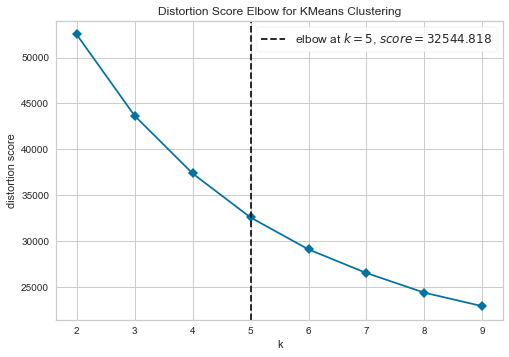

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [111]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans,
                              k=(2, 10),
                              timings=False)
# By default, the scoring parameter metric is set to distortion,
# which computes the sum of squared distances from each point
# to its assigned center.
visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.show()

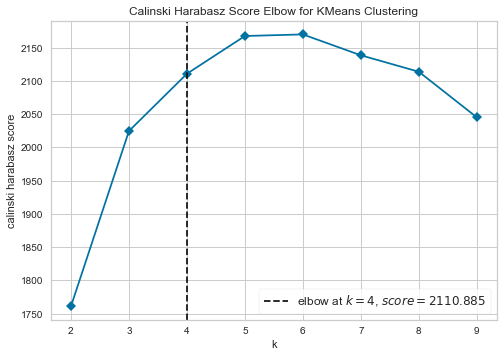

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [112]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans,
                              k=(2, 10),
                              metric='calinski_harabasz',  # 'silhouette'
                              timings=False)
# calinski_harabasz score computes the ratio
# of dispersion between and within clusters.
# (v_interGroup/v_intraGroup)
visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.show()

### Clustering

Pour la suite, nous prendrons **5** clusters.

In [315]:
# Create a k-means clustering model. Initialisation des centroïdes avec pca
pca_km = PCA(n_components=5).fit(X_scaled)
kmeans = KMeans(init=pca_km.components_, n_clusters=5, n_init=1)

In [316]:
palette = ['orange', 'blue', 'green', 'magenta', 'red']

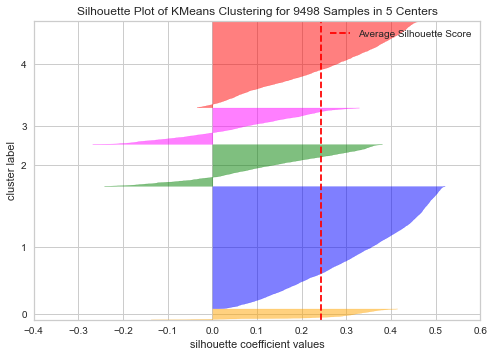

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 9498 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [317]:
# Instantiate the clustering model and visualizer
visualizer_5means = SilhouetteVisualizer(kmeans, colors=palette)
visualizer_5means.fit(X_scaled)    # Fit the data to the visualizer
visualizer_5means.show()    # Draw/show/poof the data

In [318]:
# entrainement du k-means avec la valeur 5
start_time = time.time()

# Fit the data to the model
kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to:
clusters_km = kmeans.predict(X_scaled)

df_comparaison.loc['k-means', 'execution_time'] = round(time.time() - start_time, 2)

In [319]:
sil_score = round(silhouette_score(X_scaled, clusters_km), 2)
print("silhouette_score: ", sil_score)
df_comparaison.loc['k-means', 'silhouette_score'] = sil_score

silhouette_score:  0.24


In [320]:
colors_map = {i: palette[i] for i in range(5)}

# Add cluster number and color to the original data scaled
df = X_scaled.copy()
df['cluster'] = clusters_km
df['color'] = df['cluster'].map(colors_map)
X_scaled_clustered_km = df.copy()
display(X_scaled_clustered_km.head())

# Add cluster number and color to the original data not scaled
df = X.copy()
df['cluster'] = clusters_km
df['color'] = df['cluster'].map(colors_map)
X_clustered_km = df.copy()
display(X_clustered_km.head())

recency  frequency  monetory      avis  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1 -0.355163  -0.160613 -0.088278 -0.085575   
a5515406a3c7f2d1806bf387412d6805  0.873725  -0.160613  0.172234 -0.085575   
6594a65023bcb47539aa91b0f8e98e00 -0.420529   4.583004  0.391731 -1.610556   
3ebd2e5f948dbd9d5165184b5ca781b2 -1.374879  -0.160613 -0.114210 -0.085575   
7477908d7aea0bd43d20aa32c0416664  0.187378  -0.160613 -0.146669  0.676916   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1           -0.385083            -0.712421   
a5515406a3c7f2d1806bf387412d6805            0.435276            -0.712421   
6594a65023bcb47539aa91b0f8e98e00            1.358181            -0.712421   
3ebd2e5f948dbd9d5165184b5ca781b2           -0.077448             1.144240   
7477908d7aea0bd43d20aa32c0416664           -0.692718            -0.712421   

                                  nbr_total_article  cluster   color  
customer_unique_id                                                    
318013181d2cfb137b0c39489e36a7c1          -0.290404        1    blue  
a5515406a3c7f2d1806bf387412d6805          -0.290404        4     red  
6594a65023bcb47539aa91b0f8e98e00           1.320966        0  orange  
3ebd2e5f948dbd9d5165184b5ca781b2           1.320966        1    blue  
7477908d7aea0bd43d20aa32c0416664          -0.290404        1    blue

recency  frequency  monetory  avis  \
customer_unique_id                                                     
318013181d2cfb137b0c39489e36a7c1      234          1    145.68     4   
a5515406a3c7f2d1806bf387412d6805      422          1    204.75     4   
6594a65023bcb47539aa91b0f8e98e00      224          2    254.52     2   
3ebd2e5f948dbd9d5165184b5ca781b2       78          1    139.80     4   
7477908d7aea0bd43d20aa32c0416664      317          1    132.44     5   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1                   9                    1   
a5515406a3c7f2d1806bf387412d6805                  17                    1   
6594a65023bcb47539aa91b0f8e98e00                  26                    1   
3ebd2e5f948dbd9d5165184b5ca781b2                  12                    6   
7477908d7aea0bd43d20aa32c0416664                   6                    1   

                                  nbr_total_article  cluster   color  
customer_unique_id                                                    
318013181d2cfb137b0c39489e36a7c1                  1        1    blue  
a5515406a3c7f2d1806bf387412d6805                  1        4     red  
6594a65023bcb47539aa91b0f8e98e00                  2        0  orange  
3ebd2e5f948dbd9d5165184b5ca781b2                  2        1    blue  
7477908d7aea0bd43d20aa32c0416664                  1        1    blue

### Stabilité à l'initialisation 

Notre algorithme du K-Means testé ici est initialisé avec la méthode **pca**, ce qui annule les effets aléatoires de l'initialisation des centroïdes et le rend déterministe. Nous allons vérifier ce caractère déterministe en entrainant plusieurs fois le modèle.  

Pour les labels initiaux, nous allons conserver les clusters calculés dans le dernier modèle (avec PCA) puis les comparer grâce à l'indice de Rand ajusté (ARI) pour chacune des itérations.

In [219]:
def bench_k_means(model, name, data, labels):
    t0 = time.time()
    estimator = model.fit(data)
    fit_time = time.time() - t0
    results = [name, fit_time]
    
    # ARI metrics on pred labels
    results += [adjusted_rand_score(labels, estimator.labels_)]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t\t{:.3f}")
    print(formatter_result.format(*results))

In [321]:
print("Scores de stabilité à l'initialisation")
print(40 * '_')
print('Iteration\tFitTime\t\tARI')
print(40 * '_')
 
for i in range(10):
    pca_km = PCA(n_components=5).fit(X_scaled)
    imodel = KMeans(init=pca_km.components_, n_clusters=5, n_init=1)
    #imodel = KMeans(n_clusters=5, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i),
                  data=X_scaled, labels=clusters_km)

print(40 * '_')

Scores de stabilité à l'initialisation
________________________________________
Iteration	FitTime		ARI
________________________________________
Iter 0   	0.044s		1.000
Iter 1   	0.033s		1.000
Iter 2   	0.034s		1.000
Iter 3   	0.034s		1.000
Iter 4   	0.034s		1.000
Iter 5   	0.035s		1.000
Iter 6   	0.036s		1.000
Iter 7   	0.035s		1.000
Iter 8   	0.035s		1.000
Iter 9   	0.035s		1.000
________________________________________


Les différentes itérations montrent un score ARI = 1. Nous pouvons donc en déduire que le modèle K-Means initier avec pca est stable vu qu'il est déterministe. 

### Visualisation

<AxesSubplot:title={'center':'Flattened Graph of 5 Clusters'}>

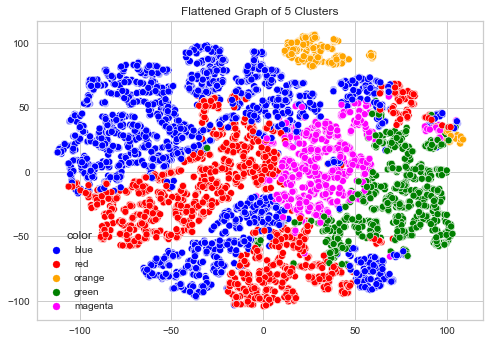

In [330]:
palette_tsne = ['blue', 'red', 'orange', 'green', 'magenta'] 
# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(5))
sns.scatterplot(x=X_tsne_10[:, 0],
                y=X_tsne_10[:, 1],
                hue=X_scaled_clustered_km.color,
                palette=palette_tsne)

In [331]:
df = X_scaled_clustered_km.copy()
df_centers_km = df.groupby('color').agg('mean')
df_centers_km['cluster_size'] = df.groupby('color').cluster.agg('count')
df_centers_km

recency  frequency  monetory      avis  nbr_jour_livraison  \
color                                                                  
blue    -0.758275  -0.160613 -0.224324  0.388295           -0.316544   
green   -0.031479  -0.160613 -0.050355 -1.954279            1.166419   
magenta  0.074646  -0.160613  0.925354  0.156559            0.006300   
orange  -0.124598   4.353909  0.588513 -0.048750           -0.011610   
red      1.000908  -0.160613 -0.208031  0.341265           -0.111965   

         nbr_versement_moyen  nbr_total_article  cluster  cluster_size  
color                                                                   
blue               -0.378583          -0.154953      1.0          3902  
green              -0.113156           0.092160      2.0          1331  
magenta             1.999390           0.031315      3.0          1162  
orange              0.125186           2.621049      0.0           352  
red                -0.330965          -0.160955      4.0          2751

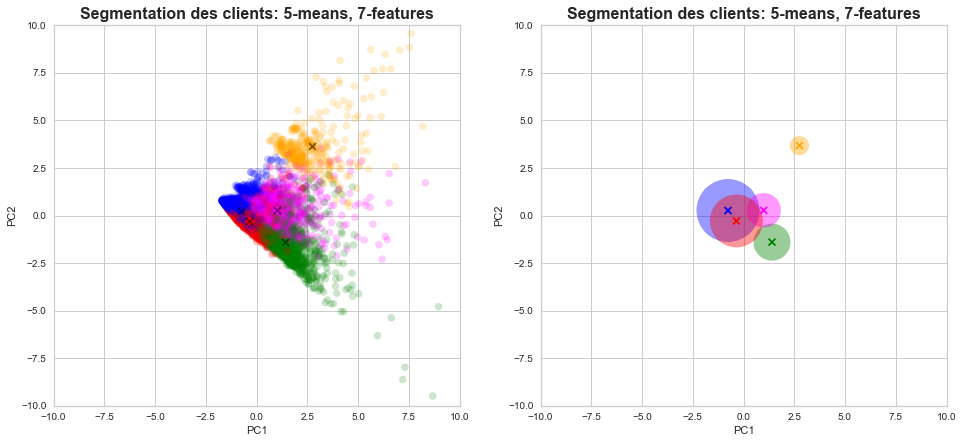

In [332]:
# Plot PCA
pca_visualisation_2d(X_scaled_clustered_km,
                     df_centers_km,
                     '5-means, 7-features',
                     pca_10)

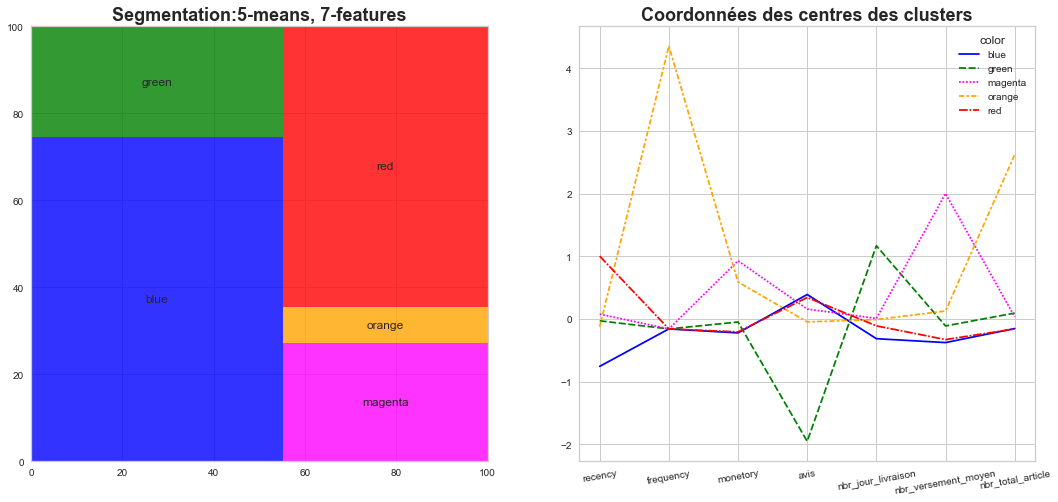

In [333]:
visualisation_centres_features(df_centers_km, '5-means, 7-features')

In [334]:
df = X_clustered_km.groupby('color').agg(lambda x: round(x.mean()))
df['cluster_size'] = X_clustered_km.groupby('color').cluster.agg('count')
df['cluster_size %'] = round(100*df['cluster_size']/df['cluster_size'].sum())\
                       .astype('int')
df_centers_invers_km = df.copy()
df_centers_invers_km

recency  frequency  monetory  avis  nbr_jour_livraison  \
color                                                             
blue         172          1       115     5                  10   
green        284          1       154     2                  24   
magenta      300          1       376     4                  13   
orange       269          2       299     4                  13   
red          441          1       119     5                  12   

         nbr_versement_moyen  nbr_total_article  cluster  cluster_size  \
color                                                                    
blue                       2                  1        1          3902   
green                      3                  1        2          1331   
magenta                    8                  1        3          1162   
orange                     3                  3        0           352   
red                        2                  1        4          2751   

         cluster_size %  
color                    
blue                 41  
green                14  
magenta              12  
orange                4  
red                  29

### Analyse des résultats

Le modèle **k-means** entrainé avec 5 clusters, 7 variables sue 10% des données donne:

* <font color='magenta'> **(Big spenders)** correspondant à 1173 clients (12% des clients étudiés) qui ont dépensé une somme importante en moyenne 374 Réal brésilien (environ 67 euros). Ils ont payé en moyenne sur 8 fois. Ils ont acheté en moyenne un seule fois et un seul article la dernière année. Ils étaient généralement satisfaits.  

* <font color='orange'> **(Loyal)** correspondant à 352 clients (4% des clients étudiés) ayant acheté plus qu'une fois et plus d'un article cette année. Ils ont dépensé également une bonne somme en moyenne 299 Réal brésilien (environ 55 euros). Ils ont payé en moyenne sur 3 fois. C'est clients sont fidèles et sont généralement satisfaits. 

* <font color='red'> **(Churned)** correspondant à 2751 clients (29% des clients étudiés) qui ont acheté en moyenne 1 fois il y a plus d'une année. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 119 Réal brésilien (environ 20 euros). Ils étaient très satisfaits. 
    
* <font color='blue'> **(New customers)** correspondant à 3901 clients (41% des clients étudiés) qui ont acheté en moyenne 1 fois dans les derniers 6 mois. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 115 Réal brésilien (environ 20 euros). Ils étaient très satisfaits.   
    
* <font color='green'> **(Unsatisfied)** correspondant à 1321 clients (14% des clients étudiés) qui n'étaient pas du tout satisfaits en partie à cause de leur grand délais de livraison. Ils ont acheté en moyenne une fois un seul article dans cette année. Ils ont dépensé en moyenne 153 Réal brésilien (environ 27 euros).  

**Les clusters 'churned' et 'new customers' partagent beaucoup de caractéristiques et se distinguent que par la récence.**  
    
**Nous retrouvons les mêmes clusters que avec 100% des données. La répartition des clients entre les clusters en % est la même que avec 100% des données. Notre échantillon de 10% est bien représentatif.**

## Clustering hiérarchique CH

### Dendrogram

In [122]:
Z = linkage(X_scaled, method="ward")
Z = pd.DataFrame(Z)

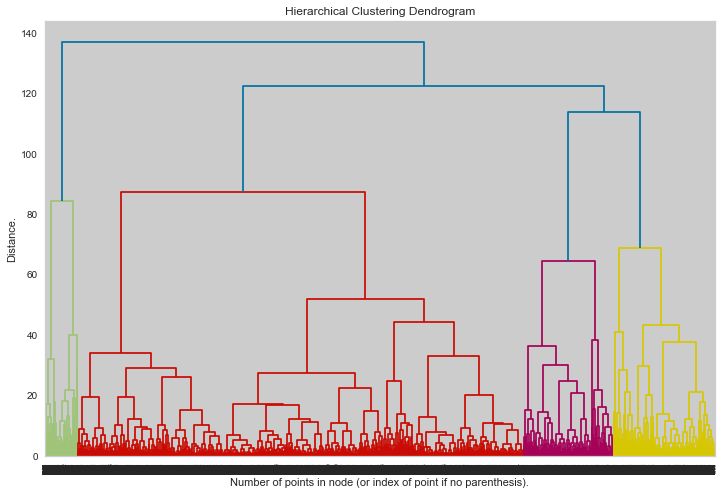

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z, ax=ax)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

### Clustering

In [124]:
start_time = time.time()
# entrainement du AgglomerativeClustering avec la valeur 5
# Create an AgglomerativeClustering clustering model
cah = AgglomerativeClustering(n_clusters=5, linkage='ward')

# Fit the data to the model
cah.fit(X_scaled)

# Determine which clusters each data point belongs to:
clusters_ch = cah.labels_

df_comparaison.loc['Agglomerative',
                   'execution_time'] = round(time.time() - start_time, 2)

In [125]:
sil_score = round(silhouette_score(X_scaled, clusters_ch), 2)
print("silhouette_score: ", sil_score)
df_comparaison.loc['Agglomerative', 'silhouette_score'] = sil_score

silhouette_score:  0.2


In [235]:
colors_map = {1: 'blue',  # bleu
              3: 'orange',  # orange
              4: 'green',  # vert
              2: 'red',  # rouge
              0: 'magenta'}  # jaune
# colors_map = {0: 'red',  # bleu
#               1: 'orange',  # orange
#               2: 'blue',  # vert
#               3: 'green',  # rouge
#               4: 'magenta'}  # jaune
# Add cluster number and color to the original data scaled
df = X_scaled.copy()
df['cluster'] = clusters_ch
df['color'] = df['cluster'].map(colors_map)
X_scaled_clustered_ch = df.copy()
display(X_scaled_clustered_ch.head())

# Add cluster number and color to the original data
df = X.copy()
df['cluster'] = clusters_ch
df['color'] = df['cluster'].map(colors_map)
X_clustered_ch = df.copy()
display(X_clustered_ch.head())

recency  frequency  monetory      avis  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1 -0.355163  -0.160613 -0.088278 -0.085575   
a5515406a3c7f2d1806bf387412d6805  0.873725  -0.160613  0.172234 -0.085575   
6594a65023bcb47539aa91b0f8e98e00 -0.420529   4.583004  0.391731 -1.610556   
3ebd2e5f948dbd9d5165184b5ca781b2 -1.374879  -0.160613 -0.114210 -0.085575   
7477908d7aea0bd43d20aa32c0416664  0.187378  -0.160613 -0.146669  0.676916   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1           -0.385083            -0.712421   
a5515406a3c7f2d1806bf387412d6805            0.435276            -0.712421   
6594a65023bcb47539aa91b0f8e98e00            1.358181            -0.712421   
3ebd2e5f948dbd9d5165184b5ca781b2           -0.077448             1.144240   
7477908d7aea0bd43d20aa32c0416664           -0.692718            -0.712421   

                                  nbr_total_article  cluster    color  
customer_unique_id                                                     
318013181d2cfb137b0c39489e36a7c1          -0.290404        3   orange  
a5515406a3c7f2d1806bf387412d6805          -0.290404        4    green  
6594a65023bcb47539aa91b0f8e98e00           1.320966        0  magenta  
3ebd2e5f948dbd9d5165184b5ca781b2           1.320966        3   orange  
7477908d7aea0bd43d20aa32c0416664          -0.290404        3   orange

recency  frequency  monetory  avis  \
customer_unique_id                                                     
318013181d2cfb137b0c39489e36a7c1      234          1    145.68     4   
a5515406a3c7f2d1806bf387412d6805      422          1    204.75     4   
6594a65023bcb47539aa91b0f8e98e00      224          2    254.52     2   
3ebd2e5f948dbd9d5165184b5ca781b2       78          1    139.80     4   
7477908d7aea0bd43d20aa32c0416664      317          1    132.44     5   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1                   9                    1   
a5515406a3c7f2d1806bf387412d6805                  17                    1   
6594a65023bcb47539aa91b0f8e98e00                  26                    1   
3ebd2e5f948dbd9d5165184b5ca781b2                  12                    6   
7477908d7aea0bd43d20aa32c0416664                   6                    1   

                                  nbr_total_article  cluster    color  
customer_unique_id                                                     
318013181d2cfb137b0c39489e36a7c1                  1        3   orange  
a5515406a3c7f2d1806bf387412d6805                  1        4    green  
6594a65023bcb47539aa91b0f8e98e00                  2        0  magenta  
3ebd2e5f948dbd9d5165184b5ca781b2                  2        3   orange  
7477908d7aea0bd43d20aa32c0416664                  1        3   orange

### Visualisation

<AxesSubplot:title={'center':'Flattened Graph of 5 Clusters'}>

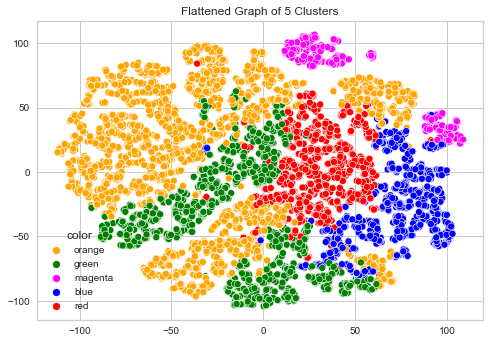

In [236]:
palette = list(X_scaled_clustered_ch.color.unique())
# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(5))
sns.scatterplot(x=X_tsne_10[:, 0],
                y=X_tsne_10[:, 1],
                hue=X_scaled_clustered_ch.color,
                palette=palette)

In [240]:
df = X_scaled_clustered_ch.copy()
df_centers_ch = df.groupby('color').agg('mean')
df_centers_ch['cluster_size'] = df.groupby('color').cluster.agg('count')
df_centers_ch

recency  frequency  monetory      avis  nbr_jour_livraison  \
color                                                                  
blue    -0.026407  -0.160613 -0.156591 -1.911603            1.038070   
green    1.094421  -0.160613 -0.239346  0.314232           -0.217387   
magenta -0.084828   3.234925  0.584449 -0.036697           -0.058385   
orange  -0.536748  -0.160613 -0.226994  0.429115           -0.233281   
red     -0.059417  -0.160613  0.809210 -0.006549            0.112705   

         nbr_versement_moyen  nbr_total_article  cluster  cluster_size  
color                                                                   
blue               -0.305821           0.016945      1.0          1274  
green              -0.213997          -0.290404      4.0          2054  
magenta             0.157195           2.877247      0.0           468  
orange             -0.443348          -0.131680      3.0          4274  
red                 1.736343          -0.122271      2.0          1428

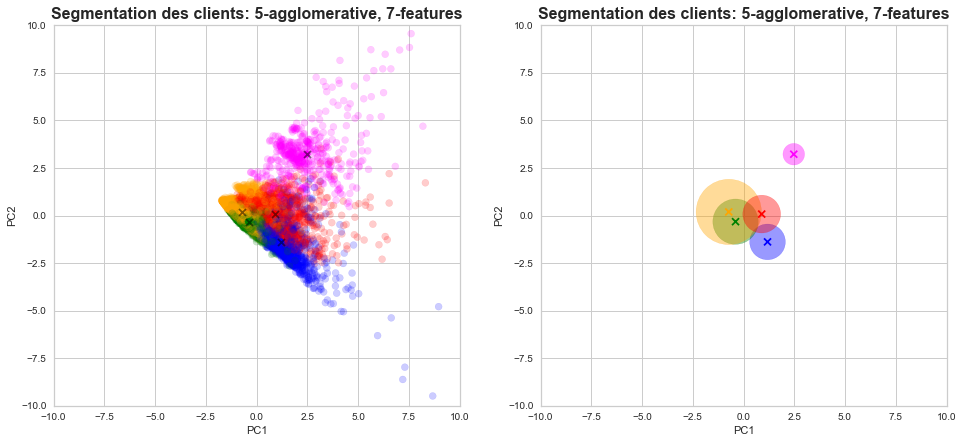

In [241]:
# Plot PCA
pca_visualisation_2d(X_scaled_clustered_ch,
                     df_centers_ch,
                     '5-agglomerative, 7-features',
                     pca_10)

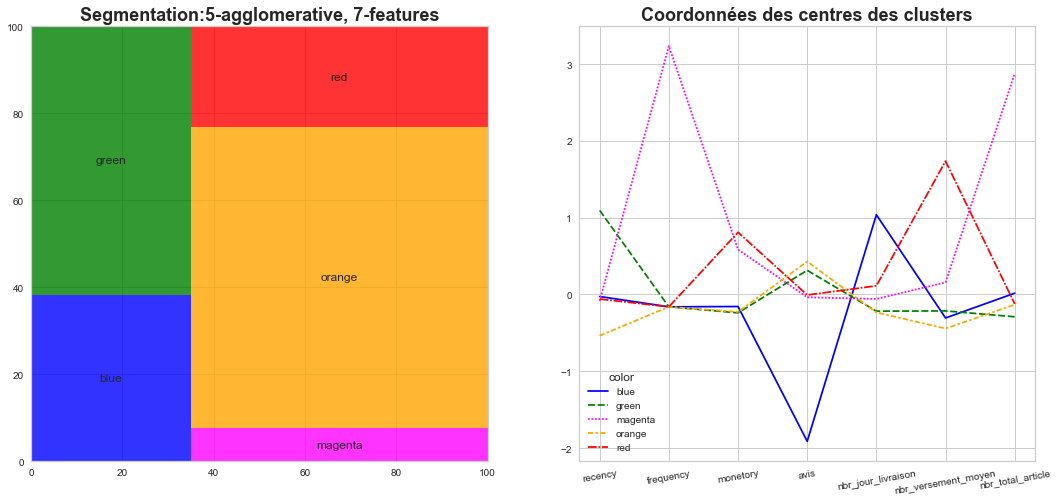

In [242]:
visualisation_centres_features(df_centers_ch, '5-agglomerative, 7-features')

In [131]:
df = X_clustered_ch.groupby('color').agg(lambda x: round(x.mean()))
df['cluster_size'] = X_clustered_ch.groupby('color').cluster.agg('count')
df['cluster_size %'] = round(100*df['cluster_size']/df['cluster_size'].sum())\
                       .astype('int')
df_centers_invers_ch = df.copy()
df_centers_invers_ch

recency  frequency  monetory  avis  nbr_jour_livraison  \
color                                                             
blue         279          1       349     4                  14   
green        206          1       114     5                  10   
magenta      456          1       111     5                  11   
orange       284          1       130     2                  23   
red          275          2       298     4                  12   

         nbr_versement_moyen  nbr_total_article  cluster  cluster_size  \
color                                                                    
blue                       8                  1        2          1428   
green                      2                  1        3          4274   
magenta                    2                  1        4          2054   
orange                     2                  1        1          1274   
red                        3                  3        0           468   

         cluster_size %  
color                    
blue                 15  
green                45  
magenta              22  
orange               13  
red                   5

In [335]:
adjusted_rand_score(clusters_ch, clusters_km)

0.5801006678524974

### Analyse des résultats 

Le modèle **Agglomératif** entrainé avec 5 clusters, 7 variables sur 10% des données donne:

* <font color='blue'> un **'blue'** **(Big spenders)** correspondant à 1428 clients (15% des clients étudiés) qui ont dépensé une somme importante en moyenne 349 Réal brésilien (environ 60 euros). Ils ont payé en moyenne sur 8 fois. Ils ont acheté en moyenne un seule fois et un seul article la dernière année. Ils étaient généralement satisfaits.  

* <font color='red'> un **'red'** **(Loyal)** correspondant à 468 clients (5% des clients étudiés) ayant acheté plus qu'une fois et plus d'un article cette année. Ils ont dépensé également une bonne somme en moyenne 298 Réal brésilien (environ 55 euros). Ils ont payé en moyenne sur 3 fois. C'est clients sont fidèles et sont généralement satisfaits. 

* <font color='magenta'> un **'magenta'** **(Churned)** correspondant à 2054 clients (22% des clients étudiés) qui ont acheté en moyenne 1 fois il y a plus d'une année. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 111 Réal brésilien (environ 20 euros). Ils étaient très satisfaits. 
    
* <font color='green'> un **'green'** **(New customers)** correspondant à 4274 clients (45% des clients étudiés) qui ont acheté en moyenne 1 fois dans les derniers 7 mois. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 114 Réal brésilien (environ 20 euros). Ils étaient très satisfaits.   
    
* <font color='orange'> un **'orange'** **(Unsatisfied)** correspondant à 1274 clients (13% des clients étudiés) qui n'étaient pas du tout satisfaits en partie à cause de leur grand délais de livraison. Ils ont acheté en moyenne une fois un seul article dans cette année. Ils ont dépensé en moyenne 130 Réal brésilien (environ 23 euros).  

**Nous retrouvons des clusters qui se rapprochent des clusters données par le k-means en terme de caractéristiques et de taille.**

## DBSCAN

### Choix des hyperparamètres

DBSCAN utilise la notion de densité pour partitionner les données tout en étant robuste au bruit.

Pour chaque observation x du jeu de données, DBSCAN assigne un des trois types suivants :

* point central (core point) si son voisinage est dense, c’est-à-dire si le nombre de points dans la boule de rayon ε centrée sur x contient plus que m points,

* point frontière (border point) si ce n’est pas un point central mais qu’il appartient au voisinage d’un tel point, c’est-à-dire qu’il existe un point central dans la boule de rayon ε centrée sur x,

* point aberrant (noise point) si ce n’est ni un point central, ni un point frontière.

Lorsque l’on trouve un point central, on lui assigne une étiquette de groupe. Tous les points dans son voisinage (qui sont nécessairement soit des points centraux, soit des points frontières) reçoivent la même étiquette. On répète le processus pour tous les points centraux du voisinage.

Observons que DBSCAN ne nécessite à aucun moment de préciser à l’avance le nombre de groupes recherchés ! Cette propriété est un des avantages de DBSCAN avec la robustesse au bruit. En effet, les points aberrants ne sont assignés à aucun groupe (contrairement à k-means) et peuvent donc être « rejetés » de l’analyse.



DBSCAN requiert deux paramètres principaux :

* ε qui définit la taille du voisinage (le rayon de la boule),

* m qui définit la densité minimale à dépasser (le nombre de voisins dans la boule pour être considéré un point central).

Ces paramètres peuvent être réglés à l’aide de connaissances expertes sur les données mais cela n’est pas toujours possible si l’on ne maîtrise pas bien les données.

Le choix de ε est le plus difficile. Si ε est choisi faible, alors peu de points seront considérés comme voisins (ni centraux, ni frontières). La majorité des points sera considérée comme aberrants, ce qui n’est pas informatif. À l’inverse, choisir une valeur trop élevée de ε rendra presque tous les points voisins les uns des autres, ce qui tend à réduire le nombre de groupes obtenus. Dans le cas extrême, DBSCAN regroupe tous les points dans une même classe, ce qui n’est pas non plus utile.

En pratique, on souhaite choisir la valeur la plus faible possible pour ε. Cela permet d’avoir la meilleure tolérance au bruit. Une règle usuelle est d’inspecter le plus grand cluster obtenu avec DBSCAN: si celui-ci regroupe une grande partie du jeu de données (par exemple, au-delà de 30%), alors il faut réduire ε
 pour le sous-diviser.

**1er essai**

In [246]:
dbscan_params_1 = dict({'eps': np.round(np.arange(1, 3, 0.2), 2),
                        'min_sample': np.arange(1, 10, 1)})
df_eps_min_1 = pd.DataFrame({})
for eps in dbscan_params_1['eps']:
    for min_sample in dbscan_params_1['min_sample']:
        df_eps_min_1 = pd.concat([df_eps_min_1,
                                  dbscan_function(eps, min_sample)],
                                  ignore_index=True)

df_eps_min_1

eps  min_sample  n_clusters  noise %  silhouette score  cluster_0 %  \
0   1.0           1         400        0             -0.02           86   
1   1.0           2          54        4              0.08           86   
2   1.0           3          20        4              0.14           86   
3   1.0           4          11        5              0.14           86   
4   1.0           5           9        5              0.14           85   
5   1.0           6           8        6              0.15           85   
6   1.0           7           7        6              0.15           85   
7   1.0           8           6        7              0.14           85   
8   1.0           9           5        7              0.16           85   
9   1.2           1         269        0              0.07           86   
10  1.2           2          44        2              0.13           86   
11  1.2           3          23        3              0.16           86   
12  1.2           4          15        3              0.18           86   
13  1.2           5          10        4              0.18           86   
14  1.2           6           9        4              0.16           86   
15  1.2           7           6        4              0.18           86   
16  1.2           8           6        5              0.18           86   
17  1.2           9           6        5              0.18           86   
18  1.4           1         194        0              0.11           86   
19  1.4           2          34        2              0.17           86   
20  1.4           3          19        2              0.18           86   
21  1.4           4          14        2              0.19           86   
22  1.4           5           9        3              0.19           86   
23  1.4           6           9        3              0.19           86   
24  1.4           7           7        3              0.19           86   
25  1.4           8           8        3              0.18           86   
26  1.4           9           7        3              0.19           86   
27  1.6           1         143        0              0.13           87   
28  1.6           2          27        1              0.19           87   
29  1.6           3          17        1              0.19           87   
30  1.6           4          13        2              0.19           87   
31  1.6           5          10        2              0.19           87   
32  1.6           6           9        2              0.19           87   
33  1.6           7           7        2              0.20           87   
34  1.6           8           7        3              0.20           87   
35  1.6           9           7        3              0.20           86   
36  1.8           1          96        0              0.34           96   
37  1.8           2          15        1              0.46           96   
38  1.8           3           5        1              0.51           96   
39  1.8           4           3        1              0.52           96   
40  1.8           5           3        1              0.51           96   
41  1.8           6           5        1              0.49           96   
42  1.8           7           5        2              0.51           95   
43  1.8           8           3        2              0.51           95   
44  1.8           9           3        2              0.51           95   
45  2.0           1          67        0              0.46           96   
46  2.0           2          10        1              0.50           96   
47  2.0           3           6        1              0.51           96   
48  2.0           4           3        1              0.52           96   
49  2.0           5           3        1              0.52           96   
50  2.0           6           3        1              0.52           96   
51  2.0           7           3        1              0.52           96   
52  2.0           8          

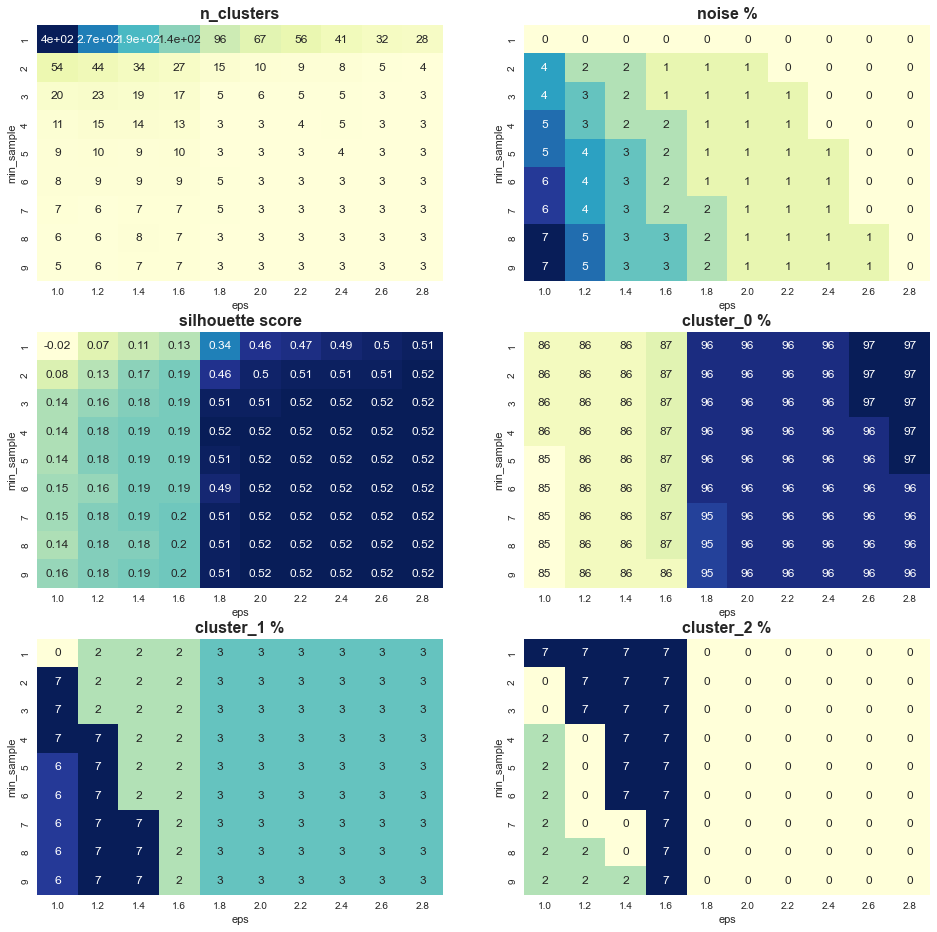

In [250]:
dbscan_eps_min_visualisation(df_eps_min_1)

**2ème essai**

In [251]:
dbscan_params_2 = dict({'eps': np.round(np.arange(0.8, 2, 0.1), 2),
                        'min_sample': np.arange(5, 16, 1)})

df_eps_min_2 = pd.DataFrame({})
for eps in dbscan_params_2['eps']:
    for min_sample in dbscan_params_2['min_sample']:
        df_eps_min_2 = pd.concat([df_eps_min_2,
                                  dbscan_function(eps, min_sample)],
                                 ignore_index=True)

df_eps_min_2

eps  min_sample  n_clusters  noise %  silhouette score  cluster_0 %  \
0    0.8           5          13        9             -0.00           83   
1    0.8           6           8       10              0.09           83   
2    0.8           7          11       11              0.05           82   
3    0.8           8           9       12              0.03           82   
4    0.8           9           7       13              0.04           81   
..   ...         ...         ...      ...               ...          ...   
127  1.9          11           3        2              0.51           95   
128  1.9          12           3        2              0.51           95   
129  1.9          13           3        2              0.51           95   
130  1.9          14           3        2              0.51           95   
131  1.9          15           3        2              0.51           95   

     cluster_1 %  cluster_2 %  cluster_3 %  cluster_4 %  
0              5            1            0            0  
1              5            0            1            0  
2              5            0            1            0  
3              1            4            1            0  
4              1            4            1            0  
..           ...          ...          ...          ...  
127            3            0            0            0  
128            3            0            0            0  
129            3            0            0            0  
130            3            0            0            0  
131            3            0            0            0  

[132 rows x 10 columns]

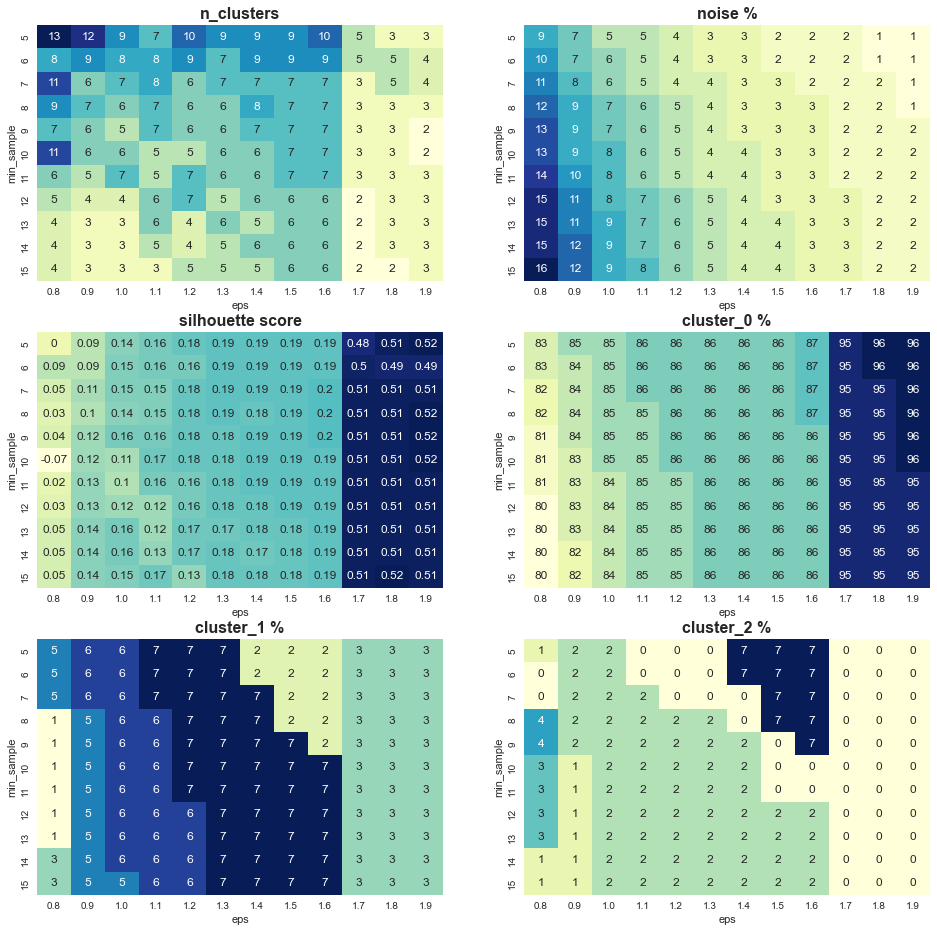

In [252]:
dbscan_eps_min_visualisation(df_eps_min_2)

**3eme essai**

In [253]:
dbscan_params_3 = dict({'eps': np.round(np.arange(1, 2.1, 0.1), 2),
                        'min_sample': np.arange(15, 26, 1)})

df_eps_min_3 = pd.DataFrame({})
for eps in dbscan_params_3['eps']:
    for min_sample in dbscan_params_3['min_sample']:
        df_eps_min_3 = pd.concat([df_eps_min_3,
                                  dbscan_function(eps, min_sample)],
                                 ignore_index=True)

df_eps_min_3

eps  min_sample  n_clusters  noise %  silhouette score  cluster_0 %  \
0    1.0          15           3        9              0.15           84   
1    1.0          16           3       10              0.16           83   
2    1.0          17           3       10              0.15           83   
3    1.0          18           3       10              0.15           83   
4    1.0          19           3       10              0.15           83   
..   ...         ...         ...      ...               ...          ...   
116  2.0          21           2        2              0.52           95   
117  2.0          22           2        2              0.52           95   
118  2.0          23           2        2              0.52           95   
119  2.0          24           2        2              0.52           95   
120  2.0          25           2        2              0.52           95   

     cluster_1 %  cluster_2 %  cluster_3 %  cluster_4 %  
0              5            2            0            0  
1              5            2            0            0  
2              5            2            0            0  
3              5            1            0            0  
4              5            1            0            0  
..           ...          ...          ...          ...  
116            3            0            0            0  
117            3            0            0            0  
118            3            0            0            0  
119            3            0            0            0  
120            3            0            0            0  

[121 rows x 10 columns]

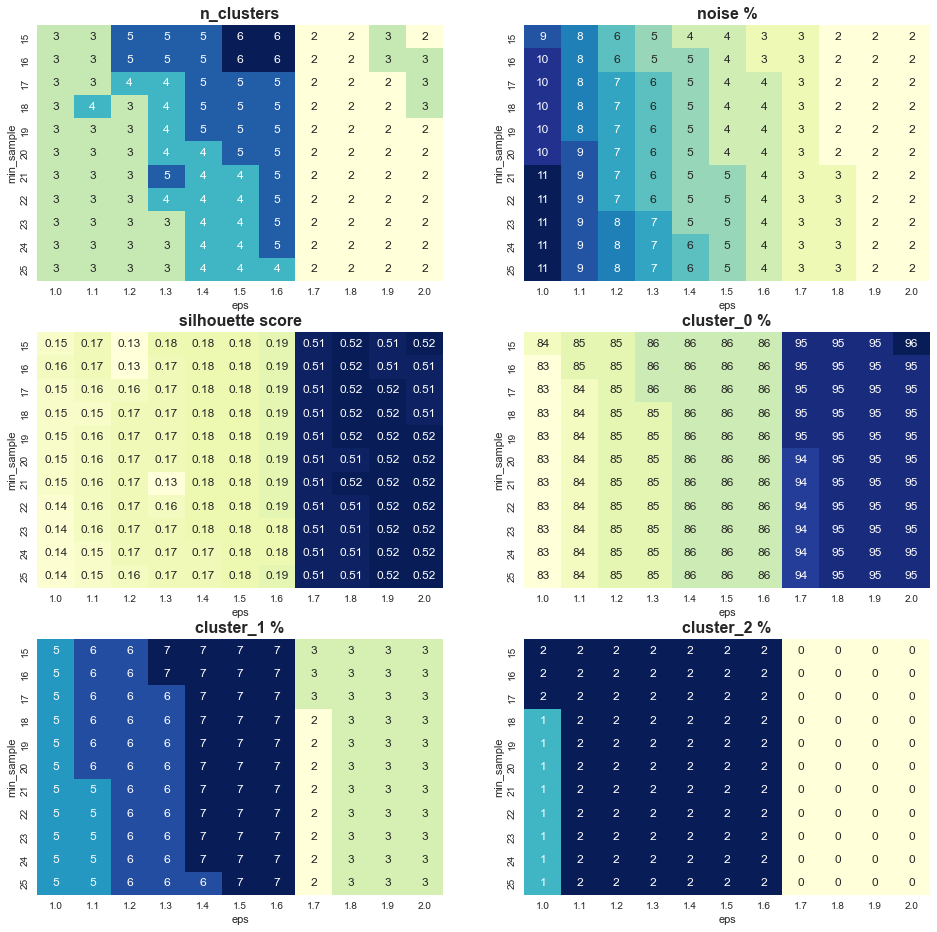

In [254]:
dbscan_eps_min_visualisation(df_eps_min_3)

**essai 4**

In [255]:
dbscan_params_4 = dict({'eps': np.round(np.arange(0.2, 1.9, 0.1), 2),
                        'min_sample': np.arange(10, 21, 1)})

df_eps_min_4 = pd.DataFrame({})
for eps in dbscan_params_4['eps']:
    for min_sample in dbscan_params_4['min_sample']:
        df_eps_min_4 = pd.concat([df_eps_min_4,
                                  dbscan_function(eps, min_sample)],
                                 ignore_index=True)

df_eps_min_4

eps  min_sample  n_clusters  noise %  silhouette score  cluster_0 %  \
0    0.2          10          17       74             -0.42           20   
1    0.2          11          14       76             -0.41           19   
2    0.2          12          13       77             -0.41           18   
3    0.2          13          13       78             -0.41           18   
4    0.2          14          11       79             -0.40           17   
..   ...         ...         ...      ...               ...          ...   
182  1.8          16           2        2              0.52           95   
183  1.8          17           2        2              0.52           95   
184  1.8          18           2        2              0.52           95   
185  1.8          19           2        2              0.52           95   
186  1.8          20           2        2              0.51           95   

     cluster_1 %  cluster_2 %  cluster_3 %  cluster_4 %  
0              0            1            0            0  
1              1            0            2            0  
2              0            0            1            2  
3              0            0            1            2  
4              0            0            0            0  
..           ...          ...          ...          ...  
182            3            0            0            0  
183            3            0            0            0  
184            3            0            0            0  
185            3            0            0            0  
186            3            0            0            0  

[187 rows x 10 columns]

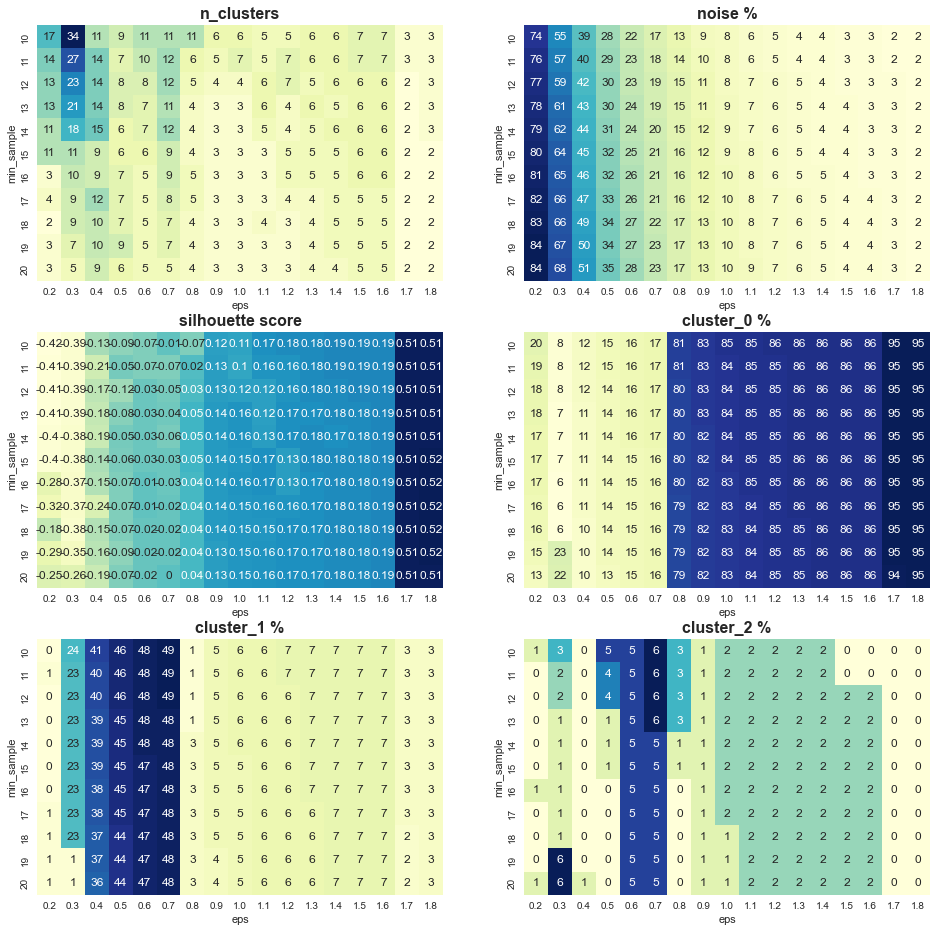

In [256]:
dbscan_eps_min_visualisation(df_eps_min_4)

In [257]:
df_eps_min_4.loc[(df_eps_min_4['min_sample'] == 14) &
                 (df_eps_min_4['silhouette score'] > 0), :]

eps  min_sample  n_clusters  noise %  silhouette score  cluster_0 %  \
70   0.8          14           4       15              0.05           80   
81   0.9          14           3       12              0.14           82   
92   1.0          14           3        9              0.16           84   
103  1.1          14           5        7              0.13           85   
114  1.2          14           4        6              0.17           85   
125  1.3          14           5        5              0.18           86   
136  1.4          14           6        4              0.17           86   
147  1.5          14           6        4              0.18           86   
158  1.6          14           6        3              0.19           86   
169  1.7          14           2        3              0.51           95   
180  1.8          14           3        2              0.51           95   

     cluster_1 %  cluster_2 %  cluster_3 %  cluster_4 %  
70             3            1            1            0  
81             5            1            0            0  
92             6            2            0            0  
103            6            2            0            0  
114            6            2            0            0  
125            7            2            0            0  
136            7            2            0            0  
147            7            2            0            1  
158            7            2            0            1  
169            3            0            0            0  
180            3            0            0            0

In [258]:
df_eps_min_4.loc[(df_eps_min_4['min_sample'] == 14) &
                 (df_eps_min_4['eps'] == 1.3), :]

eps  min_sample  n_clusters  noise %  silhouette score  cluster_0 %  \
125  1.3          14           5        5              0.18           86   

     cluster_1 %  cluster_2 %  cluster_3 %  cluster_4 %  
125            7            2            0            0

**Conclusion**

Pour la suite, nous choisissons eps=1.3 et min_sample=14 (2*7 features).

### Clustering

In [259]:
start_time = time.time()
# entrainement du DBSCAN
# Create DBSCAN clustering model
dbscan = DBSCAN(eps=1.3, min_samples=14)

# Fit the data to the model
dbscan.fit(X_scaled)

# Determine which clusters each data point belongs to:
clusters_dbscan = dbscan.labels_

df_comparaison.loc['DBSCAN',
                   'execution_time'] = round(time.time() - start_time, 2)

In [260]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_ = round(100*list(clusters_dbscan).count(-1)/len(clusters_dbscan))

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated noise points: {} %".format(n_noise_))

Estimated number of clusters: 5
Estimated noise points: 5 %


In [261]:
# Répartition des clients dans les clusters en %
clust = clusters_dbscan [clusters_dbscan  >= 0]
np.round(100*np.bincount(clust)/len(clusters_dbscan), 1)

array([85.7,  6.7,  1.9,  0.4,  0.2])

In [262]:
# Silhouette_score
sil_score = round(silhouette_score(X_scaled, clusters_dbscan), 2)
print("silhouette_score: ", sil_score)
df_comparaison.loc['DBSCAN', 'silhouette_score'] = sil_score

silhouette_score:  0.18


In [263]:
colors_map = {-1: 'black',  # noir
              3: 'blue',  # bleu
              1: 'magenta',
              0: 'green',  # vert
              2: 'red',  # rouge
              4: 'orange'}  # orange

# Add cluster number and color to the original data scaled
df = X_scaled.copy()
df['cluster'] = clusters_dbscan
df['color'] = df['cluster'].map(colors_map)
X_scaled_clustered_dbscan = df.copy()
display(X_scaled_clustered_dbscan.head())

# Add cluster number and color to the original data not scaled
df = X.copy()
df['cluster'] = clusters_dbscan
df['color'] = df['cluster'].map(colors_map)
X_clustered_dbscan = df.copy()
display(X_clustered_dbscan.head())

recency  frequency  monetory      avis  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1 -0.355163  -0.160613 -0.088278 -0.085575   
a5515406a3c7f2d1806bf387412d6805  0.873725  -0.160613  0.172234 -0.085575   
6594a65023bcb47539aa91b0f8e98e00 -0.420529   4.583004  0.391731 -1.610556   
3ebd2e5f948dbd9d5165184b5ca781b2 -1.374879  -0.160613 -0.114210 -0.085575   
7477908d7aea0bd43d20aa32c0416664  0.187378  -0.160613 -0.146669  0.676916   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1           -0.385083            -0.712421   
a5515406a3c7f2d1806bf387412d6805            0.435276            -0.712421   
6594a65023bcb47539aa91b0f8e98e00            1.358181            -0.712421   
3ebd2e5f948dbd9d5165184b5ca781b2           -0.077448             1.144240   
7477908d7aea0bd43d20aa32c0416664           -0.692718            -0.712421   

                                  nbr_total_article  cluster    color  
customer_unique_id                                                     
318013181d2cfb137b0c39489e36a7c1          -0.290404        0    green  
a5515406a3c7f2d1806bf387412d6805          -0.290404        0    green  
6594a65023bcb47539aa91b0f8e98e00           1.320966       -1    black  
3ebd2e5f948dbd9d5165184b5ca781b2           1.320966        1  magenta  
7477908d7aea0bd43d20aa32c0416664          -0.290404        0    green

recency  frequency  monetory  avis  \
customer_unique_id                                                     
318013181d2cfb137b0c39489e36a7c1      234          1    145.68     4   
a5515406a3c7f2d1806bf387412d6805      422          1    204.75     4   
6594a65023bcb47539aa91b0f8e98e00      224          2    254.52     2   
3ebd2e5f948dbd9d5165184b5ca781b2       78          1    139.80     4   
7477908d7aea0bd43d20aa32c0416664      317          1    132.44     5   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
318013181d2cfb137b0c39489e36a7c1                   9                    1   
a5515406a3c7f2d1806bf387412d6805                  17                    1   
6594a65023bcb47539aa91b0f8e98e00                  26                    1   
3ebd2e5f948dbd9d5165184b5ca781b2                  12                    6   
7477908d7aea0bd43d20aa32c0416664                   6                    1   

                                  nbr_total_article  cluster    color  
customer_unique_id                                                     
318013181d2cfb137b0c39489e36a7c1                  1        0    green  
a5515406a3c7f2d1806bf387412d6805                  1        0    green  
6594a65023bcb47539aa91b0f8e98e00                  2       -1    black  
3ebd2e5f948dbd9d5165184b5ca781b2                  2        1  magenta  
7477908d7aea0bd43d20aa32c0416664                  1        0    green

In [264]:
df = X_scaled_clustered_dbscan.copy()
df_centers_dbscan = df.groupby('color').agg('mean')
df_centers_dbscan['cluster_size'] = df.groupby('color').cluster.agg('count')
df_centers_dbscan

recency  frequency  monetory      avis  nbr_jour_livraison  \
color                                                                  
black    0.170242   1.353734  1.877336 -0.669130            0.828329   
blue    -0.366323  -0.160613  0.167647  0.249177           -0.315052   
green   -0.021717  -0.160613 -0.145832  0.064264           -0.027297   
magenta -0.078028  -0.160613  0.056521 -0.295050           -0.182408   
orange  -0.263339  -0.160613  0.199733 -2.227811           -0.389966   
red     -0.205247   4.583004  0.109231  0.192071           -0.106986   

         nbr_versement_moyen  nbr_total_article  cluster  cluster_size  
color                                                                   
black               0.894592           2.394078     -1.0           473  
blue               -0.495056           2.932337      3.0            41  
green              -0.070822          -0.290404      0.0          8142  
magenta             0.030244           1.320966      1.0           637  
orange             -0.075851           2.932337      4.0            21  
red                -0.080752           1.320966      2.0           184

### Visualisation

<AxesSubplot:title={'center':'Flattened Graph of 5 Clusters'}>

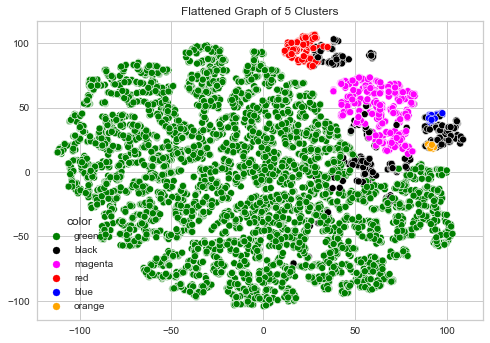

In [265]:
palette = list(X_scaled_clustered_dbscan.color.unique())
# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(5))
sns.scatterplot(x=X_tsne_10[:, 0],
                y=X_tsne_10[:, 1],
                hue=X_scaled_clustered_dbscan.color,
                palette=palette)

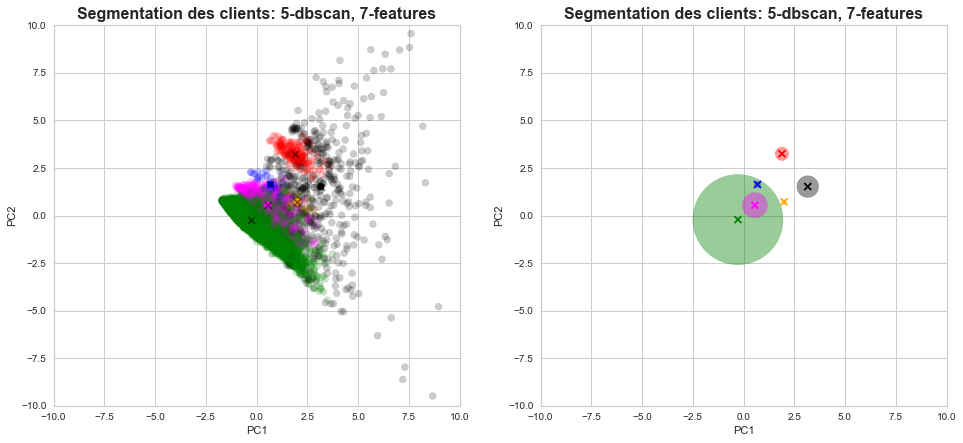

In [336]:
# Plot PCA
pca_visualisation_2d(X_scaled_clustered_dbscan,
                     df_centers_dbscan,
                     '5-dbscan, 7-features',
                     pca_10)

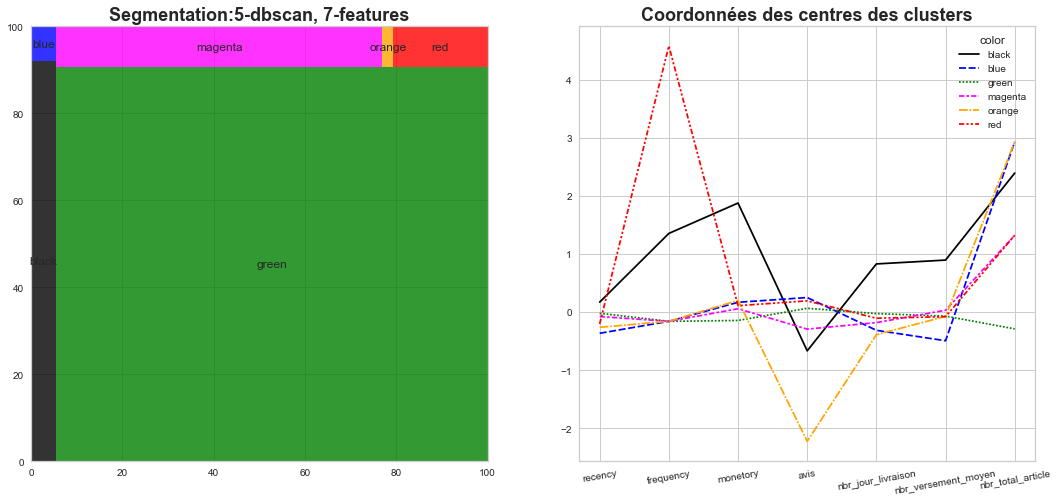

In [337]:
visualisation_centres_features(df_centers_dbscan, '5-dbscan, 7-features')

In [338]:
df = X_clustered_dbscan.groupby('color').agg(lambda x: round(x.mean()))
df['cluster_size'] = X_clustered_dbscan.groupby('color').cluster.agg('count')
df['cluster_size %'] = round(100*df['cluster_size']/df['cluster_size']
                             .sum(), 1)
df_centers_invers_dbscan = df.copy()
df_centers_invers_dbscan

recency  frequency  monetory  avis  nbr_jour_livraison  \
color                                                             
black        314          1       591     3                  21   
blue         232          1       204     4                  10   
green        285          1       133     4                  12   
magenta      276          1       179     4                  11   
orange       248          1       211     1                   9   
red          257          2       190     4                  12   

         nbr_versement_moyen  nbr_total_article  cluster  cluster_size  \
color                                                                    
black                      5                  3       -1           473   
blue                       2                  3        3            41   
green                      3                  1        0          8142   
magenta                    3                  2        1           637   
orange                     3                  3        4            21   
red                        3                  2        2           184   

         cluster_size %  
color                    
black               5.0  
blue                0.4  
green              85.7  
magenta             6.7  
orange              0.2  
red                 1.9

### Analyse des résultats 

Le modèle **DBSCAN** (eps=1.3, min_samples=14) entrainé avec 5 clusters, 7 variables sur 10% des données donne:

* <font color='black'> un **'black'** **(Atypique)** correspondant à 473 clients non classés (5% des clients étudiés). Ces clients ont été détectés comme bruit et ils n'étaient pas classés. Ces clients ont un profil atypique par rapport au dépenses, nombre de jour pour la livraison ou le nombre de versements. 
    
* <font color='green'> un **'green'** **(Low spenders)** correspondant à 8142 clients (85% des clients étudiés) qui ont dépensé en moyenne 133 Réal brésilien (environ 25 euros). Ils ont payé en moyenne sur 3 fois. Ils ont acheté en moyenne une seule fois et un seul article la dernière année. Ils étaient généralement satisfaits.  

* <font color='red'> un **'red'** **(Loyal)** correspondant à 184 clients (2% des clients étudiés) ayant acheté plus qu'une fois et plus d'un article cette année. Ils ont dépensé en moyenne 190 Réal brésilien (environ 35 euros). Ils ont payé en moyenne sur 3 fois. C'est clients sont fidèles et sont généralement satisfaits. 

* <font color='orange'> un **'orange'** **(Unsatisfied)** correspondant à 21 clients (0.2% des clients étudiés) qui n'étaient pas du tout satisfaits. Ils ont acheté en moyenne une fois 3 article dans cette année. Ils ont dépensé en moyenne 211 Réal brésilien (environ 38 euros).  
    
* <font color='magenta'> un **'magenta'**  correspondant à 637 clients (6.7% des clients étudiés) qui ont acheté en moyenne 1 fois dans l'année. Ils ont acheté deux articles, et effectué en moyenne 3 versements. Ils ont payé 179 Réal brésilien (environ 32 euros). Ils étaient satisfaits. 
    
* <font color='blue'> un **'blue'** **(New customers)** correspondant à 41 clients (0.4% des clients étudiés) qui ont acheté en moyenne 1 fois dans les derniers 8 mois. Ils ont acheté 3 articles, et effectué en moyenne 2 versements. Ils ont payé une de 204 Réal brésilien (environ 36 euros). Ils étaient satisfaits.   
    

**Les clusters ne sont pas bien équilibrés, ni bien définis.**

## Comparaison entre les modèles

In [269]:
df_comparaison

execution_time  silhouette_score
k-means                  0.47              0.24
Agglomerative            5.15              0.20
DBSCAN                   2.14              0.18

In [270]:
df = df_centers_invers_km.copy()
df_size_km_ = df['cluster_size %'].sort_values(ascending=False)\
    .reset_index(drop=True)
df_size = pd.DataFrame(df_size_km_).T
df_size.rename(index={'cluster_size %': 'k-means'}, inplace=True)
df_size

0   1   2   3  4
k-means  41  29  14  12  4

In [271]:
df = df_centers_invers_ch.copy()
df_size_ch_ = df['cluster_size %'].sort_values(ascending=False)\
    .reset_index(drop=True)
df_size_ch = pd.DataFrame(df_size_ch_).T
df_size_ch.rename(index={'cluster_size %': 'Agglomerative'}, inplace=True)

df_size = pd.concat([df_size, df_size_ch])
df_size

0   1   2   3  4
k-means        41  29  14  12  4
Agglomerative  45  22  15  13  5

In [272]:
df = df_centers_invers_dbscan.copy()
df_size_dbscan_ = df['cluster_size %'][1:].sort_values(ascending=False)\
    .reset_index(drop=True)
df_size_dbscan = pd.DataFrame(df_size_dbscan_).T
df_size_dbscan.rename(index={'cluster_size %': 'DBSCAN'}, inplace=True)

df_size = pd.concat([df_size, df_size_dbscan])
df_size

0     1     2     3    4
k-means        41.0  29.0  14.0  12.0  4.0
Agglomerative  45.0  22.0  15.0  13.0  5.0
DBSCAN         85.7   6.7   1.9   0.4  0.2

In [273]:
df_comparaison = df_comparaison.join(df_size)

In [274]:
df_comparaison

execution_time  silhouette_score     0     1     2     3    4
k-means                  0.47              0.24  41.0  29.0  14.0  12.0  4.0
Agglomerative            5.15              0.20  45.0  22.0  15.0  13.0  5.0
DBSCAN                   2.14              0.18  85.7   6.7   1.9   0.4  0.2

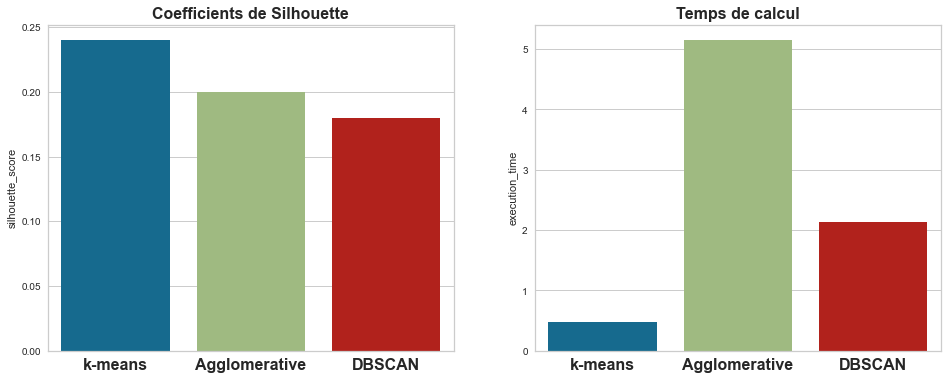

In [275]:
f, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=df_comparaison.index,
            y=df_comparaison['silhouette_score'],
            ax=axes[0])

axes[0].set_title('Coefficients de Silhouette',
                  fontsize=16, fontweight="bold")

sns.barplot(x=df_comparaison.index,
            y=df_comparaison['execution_time'],
            ax=axes[1])

axes[1].set_title('Temps de calcul',
                  fontsize=16, fontweight="bold")

for i in range(2):
    axes[i].set_xticklabels(axes[i].get_xticklabels(),
                            fontsize=16,
                            fontweight="bold")

plt.show()

Text(0.5, 1.0, "Distribution du nombre d'individus par cluster, en pourcentage")

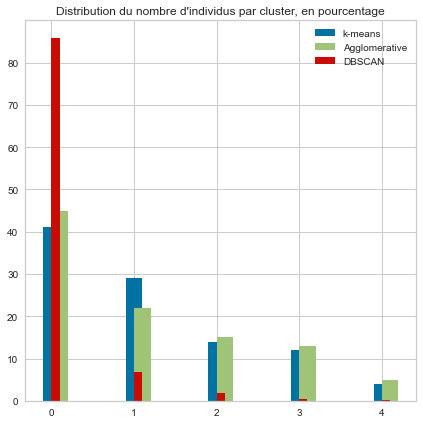

In [341]:
plt.figure(figsize=(7, 7))
df = df_size.T

plt.bar(df.index,
        df['k-means'],
        width=0.2,
        label='k-means')

plt.bar(df.index,
        df['Agglomerative'],
        align='edge',
        width=0.2,
        label='Agglomerative')

plt.bar(df.index,
        df['DBSCAN'],
        align='edge',
        width=0.1,
        label='DBSCAN')

plt.legend()
plt.title('Distribution du nombre d\'individus par cluster, en pourcentage')

# Modéle final : 5-means sur tous les données

## Prétraitement

In [277]:
# Selection des variables
data_columns = ['recency',
                'frequency',
                'monetory',
                'avis',
                'nbr_jour_livraison',
                'nbr_versement_moyen',
                'nbr_total_article']
data = olist_clients.loc[:, data_columns]

In [278]:
# scaling numerical features
scaler = StandardScaler()
data_scaled_ = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data=data_scaled_,
                           index=data.index,
                           columns=data.columns)

In [279]:
X_scaled = data_scaled.copy()
X_scaled.shape

(94983, 7)

## Clustering

In [280]:
# entrainement du k-means avec la valeur 5
# Create a k-means clustering model
kmeans = KMeans(n_clusters=5)

# Fit the data to the model
kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to:
clusters = kmeans.predict(X_scaled)

In [281]:
silhouette_score(X_scaled, clusters)

0.23976317621406776

In [282]:
colors_map = {4: 'blue',  # bleu
              2: 'orange',  # orange
              0: 'green',  # vert
              3: 'red',  # rouge
              1: 'magenta'}  # jaune
# Add cluster number and color to the original data scaled
X_scaled_clustered = X_scaled.copy()
X_scaled_clustered['cluster'] = clusters
X_scaled_clustered['color'] = X_scaled_clustered['cluster'].map(colors_map)
X_scaled_clustered.head()

# Add cluster number and color to the original data not scaled
X_clustered = data.copy()
X_clustered['cluster'] = clusters
X_clustered['color'] = X_clustered['cluster'].map(colors_map)
X_clustered.head()

recency  frequency  monetory  avis  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90     5   
0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19     4   
0000f46a3911fa3c0805444483337064      587          1     86.22     3   
0000f6ccb0745a6a4b88665a16c9f078      371          1     43.62     4   
0004aac84e0df4da2b147fca70cf8255      338          1    196.89     5   

                                  nbr_jour_livraison  nbr_versement_moyen  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2                   6                    8   
0000b849f77a49e4a4ce2b2a4ca5be3f                   3                    1   
0000f46a3911fa3c0805444483337064                  26                    8   
0000f6ccb0745a6a4b88665a16c9f078                  20                    4   
0004aac84e0df4da2b147fca70cf8255                  13                    6   

                                  nbr_total_article  cluster   color  
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2                  1        2  orange  
0000b849f77a49e4a4ce2b2a4ca5be3f                  1        0   green  
0000f46a3911fa3c0805444483337064                  1        2  orange  
0000f6ccb0745a6a4b88665a16c9f078                  1        4    blue  
0004aac84e0df4da2b147fca70cf8255                  1        2  orange

In [283]:
df = X_scaled_clustered.copy()
df_centers = df.groupby('color').agg('mean')
df_centers['cluster_size'] = df.groupby('color').cluster.agg('count')
df_centers

recency  frequency  monetory      avis  nbr_jour_livraison  \
color                                                                  
blue     0.999491  -0.160613 -0.215885  0.358785           -0.118898   
green   -0.760794  -0.160613 -0.216446  0.389091           -0.306289   
magenta  0.003128  -0.160613 -0.065936 -1.945007            1.121895   
orange   0.051740  -0.160214  1.067549  0.149905           -0.020003   
red     -0.106819   4.511792  0.766727 -0.056140           -0.030009   

         nbr_versement_moyen  nbr_total_article  cluster  cluster_size  
color                                                                   
blue               -0.303189          -0.155127      4.0         28433  
green              -0.373402          -0.160806      0.0         37761  
magenta            -0.115078           0.038684      1.0         13622  
orange              1.997964           0.044243      2.0         11903  
red                 0.155159           2.888893      3.0          3264

## Visualisation

In [284]:
tsne = TSNE(init='pca', perplexity=10)
X_tsne = tsne.fit_transform(X_scaled)

<AxesSubplot:title={'center':'Flattened Graph of 5 Clusters'}>

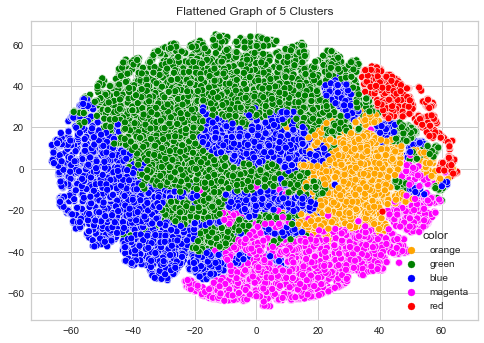

In [285]:
palette = list(X_scaled_clustered.color.unique())
# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(5))
sns.scatterplot(x=X_tsne[:, 0],
                y=X_tsne[:, 1],
                hue=X_scaled_clustered.color,
                palette=palette)

In [286]:
tsne_p5 = TSNE(init='pca', perplexity=5)
X_tsne_p5 = tsne_p5.fit_transform(X_scaled)

<AxesSubplot:title={'center':'Flattened Graph of 5 Clusters'}>

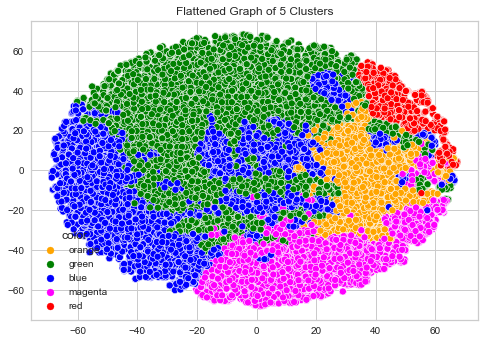

In [287]:
palette = list(X_scaled_clustered.color.unique())
# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(5))
sns.scatterplot(x=X_tsne_p5[:, 0],
                y=X_tsne_p5[:, 1],
                hue=X_scaled_clustered.color,
                palette=palette)

In [288]:
# PCA de visualisation 2D
pca = PCA(n_components=2)
pca = pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.23638784 0.19652705]
0.4329148946043456


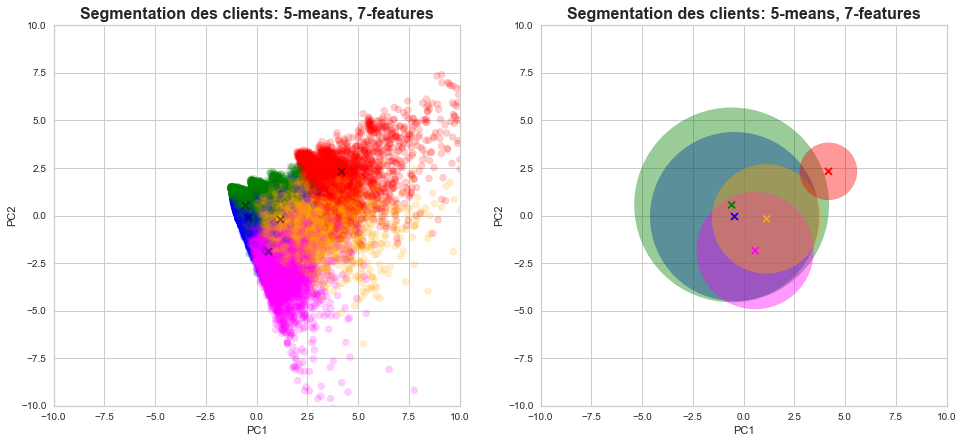

In [289]:
# Plot PCA
pca_visualisation_2d(X_scaled_clustered,
                     df_centers,
                     '5-means, 7-features',
                     pca)

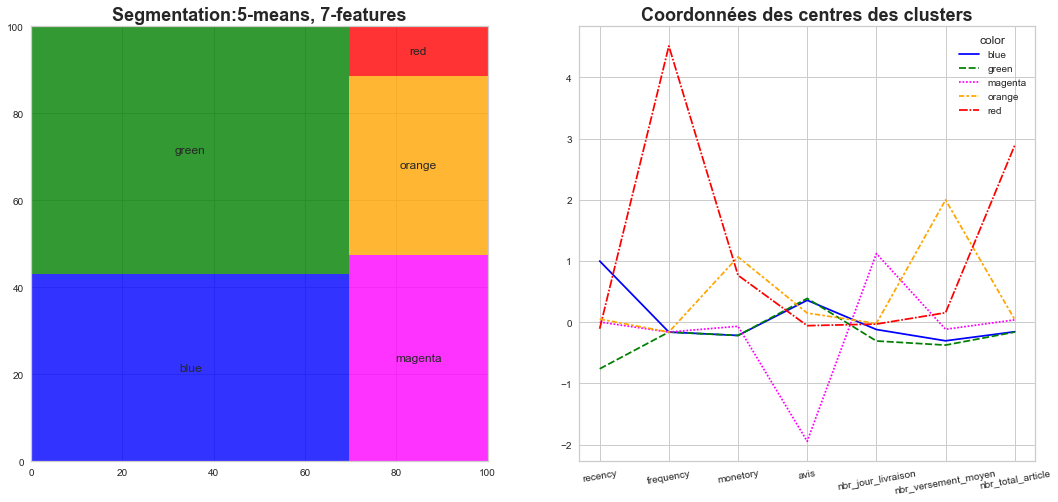

In [290]:
visualisation_centres_features(df_centers, '5-means, 7-features')

In [291]:
df = X_clustered.groupby('color').agg(lambda x: round(x.mean()))
df['cluster_size'] = X_clustered.groupby('color').cluster.agg('count')
df['cluster_size %'] = round(100*df['cluster_size']/df['cluster_size'].sum())\
                       .astype('int')
df_centers_invers = df.copy()
df_centers_invers

recency  frequency  monetory  avis  nbr_jour_livraison  \
color                                                             
blue         441          1       117     5                  12   
green        172          1       117     5                  10   
magenta      289          1       151     2                  24   
orange       296          1       408     4                  13   
red          272          2       340     4                  12   

         nbr_versement_moyen  nbr_total_article  cluster  cluster_size  \
color                                                                    
blue                       2                  1        4         28433   
green                      2                  1        0         37761   
magenta                    3                  1        1         13622   
orange                     8                  1        2         11903   
red                        3                  3        3          3264   

         cluster_size %  
color                    
blue                 30  
green                40  
magenta              14  
orange               13  
red                   3

## Analyse des résultats

Le modèle **k-means** entrainé avec 5 clusters, 7 variables sur la totalité des données donne:

* <font color='blue'> **(Big spenders)** correspondant à 11884 clients (13% des clients étudiés) qui ont dépensé une somme importante en moyenne 408 Réal brésilien (environ 75 euros). Ils ont payé en moyenne sur 8 fois. Ils ont acheté en moyenne un seule fois et un seul article la dernière année. Ils étaient généralement satisfaits.  

* <font color='red'> **(Loyal)** correspondant à 3264 clients (3% des clients étudiés) ayant acheté plus qu'une fois et plus d'un article cette année. Ils ont dépensé également une bonne somme en moyenne 340 Réal brésilien (environ 60 euros). Ils ont payé en moyenne sur 3 fois. C'est clients sont fidèles et sont généralement satisfaits. 

* <font color='magenta'> **(Churned)** correspondant à 28K clients (30% des clients) qui ont acheté en moyenne 1 fois il y a plus d'une année. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 117 Réal brésilien (environ 20 euros). Ils étaient très satisfaits. 
    
* <font color='green'> **(New customers)** correspondant à 38K clients (40% des clients) qui ont acheté en moyenne 1 fois dans les derniers 6 mois. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 117 Réal brésilien (environ 20 euros). Ils étaient très satisfaits.   
    
* <font color='orange'> **(Unsatisfied)** correspondant à 13K clients (14% des clients) qui n'étaient pas du tout satisfaits en partie à cause de leur grand délais de livraison. Ils ont acheté en moyenne une fois un seul article dans cette année. Ils ont dépensé en moyenne 150 Réal brésilien (environ 27 euros).   

# Conclusion

La démarche entamée dans le notebook pour définir un modèle ML adéquat est basée sur les étapes suivantes:

* Modélisation sur tous le jeu de données:
    * Une première modélisation ML avec les trois variables RFM en déployant le modèle KMeans: la segmentation n'est pas assez fine dans notre cas d'étude.
    * Une deuxième modélisation ML se basant sur 7 variables numériques et 1 catégorielle en déployant le modèle KMeans:  l'interprétation desclusters est difficile. 
    * Une troisième modélisation ML se basant sur 7 variables numériques uniquement en déployant le modèle KMeans: la segmentation est fine. On obtentient de 5 clusters bien caractérisés. 

* Modélisation sur 10% du jeu de données: 
    * Une première modélisation ML se basant sur 7 variables numériques uniquement en déployant le modèle KMeans: la segmentation est fine. On obtentient de 5 clusters bien caractérisés.
    * Une deuxième modélisation ML se basant sur 7 variables numériques uniquement en déployant le modèle Agglomerative: On retrouve des clusters qui se rapprochent des clusters données par le k-means en terme de caractéristiques et de taille. Toute fois, la modélisation agglomérative est très lente et elle consomme trop en terme de ressource mémoire.  
    * Une troisième modélisation ML se basant sur 7 variables numériques en déployant le modèle DBSCAN: après étude des paramètres eps et min_sample, la classification avec DBSCAN abouti à des clusters obtenus pas bien équilibrés, ni bien définis. 
    
**Le modèle retenue pour la suite du projet est le k-means en 5-clusters 7-features**

* <font color='blue'> **(Big spenders)** correspondant à 11884 clients (13% des clients étudiés) qui ont dépensé une somme importante en moyenne 408 Réal brésilien (environ 75 euros). Ils ont payé en moyenne sur 8 fois. Ils ont acheté en moyenne un seule fois et un seul article la dernière année. Ils étaient généralement satisfaits.  

* <font color='red'> **(Loyal)** correspondant à 3264 clients (3% des clients étudiés) ayant acheté plus qu'une fois et plus d'un article cette année. Ils ont dépensé également une bonne somme en moyenne 340 Réal brésilien (environ 60 euros). Ils ont payé en moyenne sur 3 fois. C'est clients sont fidèles et sont généralement satisfaits. 

* <font color='magenta'> **(Churned)** correspondant à 28K clients (30% des clients) qui ont acheté en moyenne 1 fois il y a plus d'une année. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 117 Réal brésilien (environ 20 euros). Ils étaient très satisfaits. 
    
* <font color='green'> **(New customers)** correspondant à 38K clients (40% des clients) qui ont acheté en moyenne 1 fois dans les derniers 6 mois. Ils ont acheté un seul article, et effectué en moyenne 2 versements. Ils ont payé une petite somme de 117 Réal brésilien (environ 20 euros). Ils étaient très satisfaits.   
    
* <font color='orange'> **(Unsatisfied)** correspondant à 13K clients (14% des clients) qui n'étaient pas du tout satisfaits en partie à cause de leur grand délais de livraison. Ils ont acheté en moyenne une fois un seul article dans cette année. Ils ont dépensé en moyenne 150 Réal brésilien (environ 27 euros).   